In [ ]:
#default_exp annotations

In [ ]:
#slow_all

# annotations

> A submodule containing classes and functions for organizing annotations and exon-exon junctions in terms of splice graphs.

In [ ]:
#export
import pandas as pd
from tqdm import tqdm
from copy import copy
import numpy
import scipy
import networkx as nx       # For working with graphs
import pyranges as pr       # For working with annotations
import ncls                 # For quick interval lookups
from spliceformats.parsers import FastaReader
from spliceformats.utilities import combine_items, progbar, vprint


In [ ]:
from matplotlib import pyplot
import seaborn
from IPython.display import HTML

In [ ]:
def vprint(statement, verbose=False):
    """This is a convenience function for making print statements that can be turned on when a 
    function is meant to be verbose and turned off otherwise."""
    if verbose==True:
        print (statement)

In [ ]:
vprint("Hello world", verbose=False)

In [ ]:
#export
class Feature():
    """A class for storing information about annotations in a GTF file.
    ****
    **Arguments/Attributes**:
    
    `feature`: The category of the annotation
    
    `exon_num`: Which exon the feature represents, nan is undefined
    
    `frame`: Which reading frame the feature belongs to
    
    `chrom`: The chromosome
    
    `strand`: The strand
    
    `start`: The start coordinate
    
    `end`: The end coordinate
    
    `gene_ids`: The genes in which it occurs
    
    `tx_ids`: The transcripts in which it occurs
    
    `data` (dict): A dictionary for storing additional information about the junction, such as \
        read counts
    ****
    **Additional attributes**
    
    `length`: The length of the segments (computed by as `end - start`
    """
    def __init__(self,feature, exon_num,frame, chrom, strand, start, end, gene_id, tx_id):
        self.feature=feature
        self.exon_num=exon_num
        self.frame=frame
        self.chrom=chrom
        self.strand=strand
        self.start=start
        self.end=end
        self.length=abs(end-start)
        self.tx_id=tx_id
        self.gene_id=gene_id

    def _convert_coordinates(self, start, end):
        if self.strand=='+':
            return start-self.start, end-self.start
        else:
            return start-self.start, end-self.start
            
        
    def __repr__(self):
        rep=f"{self.feature} in {self.tx_id}:: {self.chrom}({self.strand}):{self.start}-{self.end}"
        return rep

In [ ]:
#export
class GenomicIntervals():
    def __init__(self, df,chrom_col, start_col, end_col, strand_col=None,):
        self.df=df
        self.chroms=annot_df[chrom_col].values
        self.starts=annot_df[start_col].values
        self.ends=annot_df[end_col].values
        if isinstance(strand_col,type(None))==False:
            self.strands=annot_df[strand_col].values
        else:
            self.strands=numpy.zeros(len(self.chroms))
        self.annot_ids=numpy.arange(len(self.chroms))
        
        chrom_set=set(self.chroms)
        for chrom in chrom_set:
            self.lookup_dict[chrom]={}
            for strand in ['-','+']:
                filter_ind=(self.chroms==chrom)&(self.strands==strand)
                start_subset=self.starts[filter_ind]
                end_subset=self.ends[filter_ind]
                id_subset=self.annot_ids[filter_ind]
                self.lookup_dict[chrom][strand]=ncls.NCLS(start_subset,end_subset, id_subset)

    def query(self, chrom, strand, start, end):
        idx=[ind for ind in self.lookup_dict[chrom][strand].find_overlap(start,end)]
        return self.df.iloc[idx]

        

        

In [ ]:
#export
class AnnotationBrowser():
    def __init__(self, annot_df):
        self.tx_ids=annot_df['transcript_id'].values
        self.gene_ids=annot_df['gene_id'].values
        self.chroms=annot_df['Chromosome'].values
        self.starts=annot_df['Start'].values
        self.ends=annot_df['End'].values
        self.strands=annot_df['Strand'].values
        self.frames=annot_df['Frame'].values
        self.features=annot_df['Feature'].values
        
        try:
            self.exon_nums=annot_df['exon_number'].values
        except:
            self.exon_nums=numpy.arange(len(self.features))*numpy.nan
        self.annot_ids=numpy.arange(len(self.features))
        self.lookup_dict={}
        self.info_dict={}
        for i in self.annot_ids:
            if self.features[i]=='transcript': continue
            self.info_dict[i]=Feature(self.features[i], 
                                      self.exon_nums[i],
                                      self.frames[i], 
                                      self.chroms[i], 
                                      self.strands[i], 
                                      self.starts[i],
                                      self.ends[i], 
                                      self.gene_ids[i], 
                                      self.tx_ids[i])
        chrom_set=set(self.chroms)
        for chrom in chrom_set:
            self.lookup_dict[chrom]={}
            for strand in ['-','+']:
                filter_ind=(self.chroms==chrom)&(self.strands==strand)&(self.features!='transcript')
                start_subset=self.starts[filter_ind]
                end_subset=self.ends[filter_ind]
                id_subset=self.annot_ids[filter_ind]
                self.lookup_dict[chrom][strand]=ncls.NCLS(start_subset,end_subset, id_subset)
        self.tx_lookup={}
        self.gene_lookup={}
        for i in self.annot_ids:
            if self.features[i]=='transcript': continue
            tx=self.tx_ids[i]
            gene=self.gene_ids[i]
            if tx not in self.tx_lookup:
                self.tx_lookup[tx]=[]
            if gene not in self.gene_lookup:
                self.gene_lookup[gene]=[]

            self.tx_lookup[tx].append(self.info_dict[i])
            self.gene_lookup[gene].append(self.info_dict[i])
            
    def query(self, chrom, strand, start, end):
        res=[self.info_dict[annot_id[-1]] for annot_id in self.lookup_dict[chrom][strand].find_overlap(start,end)]
        return AnnotationQueryResult(res)
    def extract_transcript(self, tx_id):
        return AnnotationQueryResult(self.tx_lookup[tx_id])
    def extract_gene(self, gene_id):
        return AnnotationQueryResult(self.gene_lookup[gene_id])
        

        

In [ ]:
#export
class AnnotationQueryResult():
    def __init__(self,results):
        self.results=results
        self.tx_features={}
        for res in self.results:
            if res.tx_id not in self.tx_features:
                self.tx_features[res.tx_id]=[]
            self.tx_features[res.tx_id].append(res)
    def get_transcripts_containing_exon(self, start, end):
        tx_matches=set()
        for tx_id in self.tx_features:
            for annot in self.tx_features[tx_id]:
                if annot.feature!='exon': continue
                if annot.start!=start or annot.end!=end: continue
                tx_matches.add(tx_id)
        tx_res={}
        for match in tx_matches:
            tx_res[match]=self.tx_features[match]
        return tx_res
                    
        
            
        

### Strategy for representing a gene's transcripts as a graph

A multiple transcripts may be generated from a single gene. This is complexity is generated by the alternative usage of transcription start and end sites by the transcription machinery and by the alternative usage of 5' and 3' splice sites by the spliceosome. Sequence that is exonic in one transcript may have been spliced out as an intron 

In [ ]:
# annot=pyranges.read_gtf('/home/mpm289/projects/FIL_index/00_data/GRCh37_GENCODEV34lift37.gtf')
ens_annot=pr.read_gtf('/home/mpm289/projects/tools/spliceformats/00_data/hg19.ensGene.gtf.gz')
exon_ind=ens_annot.df['Feature']=='exon'
df=ens_annot.df[exon_ind==True]
df=df.sort_values(by=['Chromosome','Start'])
exon_annot=pr.PyRanges(df)

In [ ]:
#export
def get_exon_segments(annot):
    """Divides exons into a set of non-overlapping segments
        Arguments:
            annot (PyRanges or DataFrame): The set of exon annotations
        Returns:
            PyRanges object containing exon segments"""
    if isinstance(annot, pd.DataFrame):
        annot=pr.PyRanges(annot)
    exon_segments=annot.split()
    exon_df=exon_segments.df
    length=exon_df.shape[0]
    exon_df['ID']=numpy.arange(length)
    return pr.PyRanges(exon_df)

In [ ]:
#export
def get_overlapping_annotations(start, end,strand, annot_dict):
    """Query the interval defined by (start,end) against a set of interval and \
    return the corresponding gene and transcript ids as lists:
    ****
    **Arguments:**
            start (int): 
            end (int): 
            annot_dict (dict): A dictionary containing the following keys:
                'intervals' : Stores an Nx2 numpy array where the first column stores start positions
                            and the second stores end positions
                'gene_ids': Stores an N length numpy array holding gene ids
                'tx_ids': Stores an N length numpy array holding transcript ids"""
#     print (start,end)
    is_contained_within=((start>=annot_dict['intervals'][:,0])*
                         (end<=annot_dict['intervals'][:,1])*
                        (strand==annot_dict['strand']))>0
    gene_ids=(annot_dict['gene_ids'][is_contained_within])
    tx_ids=(annot_dict['tx_ids'][is_contained_within])
    return gene_ids, tx_ids

In [ ]:
#export
def get_exon_segments_from_annotation(annot, verbose=True):
    """Takes a table of annotations and returns a table describing the exon segments and a dictionary 
    describing the structure of each transcript in the annotations."""
    if isinstance(annot, pd.DataFrame):
        annot=pr.PyRanges(annot)
    exon_ind=annot.df['Feature']=='exon'
    df=annot.df[exon_ind==True]
    df=df.sort_values(by=['Chromosome','Start'])
    exon_annot=pr.PyRanges(df)
#     print (exon_annot)
    ## Get the segments
    #Divide exons into nonoverlapping subsequences called exon_segments
    exon_segments=get_exon_segments(exon_annot)
    #Cluster all overlapping exons
    clustered_exons=exon_annot.cluster(strand =True)
#     print (clustered_exons)
    #Determine which group of overlapping exons each exon_segment belongs to
    #this will let us assign each exon_segment to the genes and transcripts
    #in which it occurs
    #By default this ignores the strandedness (though the documenation says otherwise)
    nearest_cluster=exon_segments.nearest(clustered_exons,strandedness ='same')
#     print (nearest_cluster)
    clustered_df=clustered_exons.df


    ## Construct lookup tables for each cluster
    starts=clustered_df['Start'].values
    ends=clustered_df['End'].values
    strands=clustered_df['Strand'].values
    gene_ids=clustered_df['gene_id'].values
    tx_ids=clustered_df['transcript_id'].values
    cluster_ids=clustered_df['Cluster'].values
    cluster_dict={}
    for i,c in progbar(enumerate(cluster_ids), verbose):
        if c not in cluster_dict:
            cluster_dict[c]={'intervals':[],
                             'strand':[],
                            'gene_ids':[],
                            'tx_ids':[]}
        cluster_dict[c]['intervals'].append([starts[i],ends[i]])
        cluster_dict[c]['strand'].append(strands[i])
        cluster_dict[c]['gene_ids'].append(gene_ids[i])
        cluster_dict[c]['tx_ids'].append(tx_ids[i])

    for c in progbar(cluster_dict.keys(), verbose):
        cluster_dict[c]['intervals']=numpy.array(cluster_dict[c]['intervals'])
        cluster_dict[c]['strand']=numpy.array(cluster_dict[c]['strand'])
        cluster_dict[c]['gene_ids']=numpy.array(cluster_dict[c]['gene_ids'])
        cluster_dict[c]['tx_ids']=numpy.array(cluster_dict[c]['tx_ids'])
        
    # Use the lookup tables to match each exon segment to all genes and transcripts 
    # in which it occurs
    nearest_df=nearest_cluster.df
#     print (nearest_df.columns)
    starts=nearest_df['Start'].values
    ends=nearest_df['End'].values
    strands=nearest_df['Strand'].values
    chromosomes=nearest_df['Chromosome'].values
    distance=nearest_df['Distance'].values
#     print (sum(distance>0))
#     print (f"Nonmatching strand: {(strands!=nearest_df['Strand_b'].values).sum()}")
    if (strands!=nearest_df['Strand_b'].values).sum()>0:
        return nearest_df[strands!=nearest_df['Strand_b'].values], 'fail'
    
    IDs=nearest_df['ID'].values
    cluster_ids=nearest_df['Cluster'].values
    gene_col=[]
    tx_col=[]
    tx_structure={}
    gene_structure={}
    
    for i,c in progbar(enumerate(cluster_ids), verbose):
        start, end=starts[i], ends[i]
        strand=strands[i]
        chrom=chromosomes[i]
        gene_ids, tx_ids=get_overlapping_annotations(start, end,strand,cluster_dict[c])
        gene_col.append(','.join(gene_ids))
        tx_col.append(','.join(tx_ids))
        if tx_col[-1]=='':
            print (i)
            print (start)
            print (end)
            print (strand)
            print (cluster_dict[c])
            print (jabber)
        for idx,tx in enumerate(tx_ids):
            if tx not in tx_structure:
                tx_structure[tx]={'gene_id':gene_ids[idx],
                                'strand':strand,
                                  'chrom':chrom,
                                 'segments':[]}
            tx_structure[tx]['segments'].append(((start,end),strand, IDs[i]) )
    for tx in tx_structure:
        strand_set=set()
        for seg in tx_structure[tx]['segments']:
            interval, strand, ID=seg
            strand_set.add(strand)
        assert(len(strand_set)==1)
    # Add this information to the table of exon segments        
    new_df=exon_segments.df
    new_df['gene_ids']=gene_col
    new_df['tx_ids']=tx_col
    
#     exon_segments=new_df.sort_values(by=['Chromosome', 'Strand', "Start"])
    exon_segments=pr.PyRanges(new_df)
    
    return exon_segments, tx_structure

In [ ]:
# segment_table

### ExonSegment

When working alignments, I'm going to want to be able to reconstruct the sequence (or possible sequences) of read pairs based on the exon segments to which they align. A read may map to some position with an exon segments, in which case I'll want to be able to extract the seq

An `ExonSegment` object stores information specific to that exon segment, including the sequence. This is where I'll handle actually slicing the sequence. There are two 



In [ ]:
# def PlotExampleSegment()

exon_segment(de

In [ ]:
#export

## Is this really the best way to handle this? Do I need a separate class or should I make this part of the TranscriptomeSegments class?
class ExonSegment():
    """A class for storing information about ExonSegments.
    ****
    **Arguments/Attributes**:
    
    `chrom`: The chromosome
    
    `strand`: The strand
    
    `start`: The start coordinate
    
    `end`: The end coordinate
    
    `gene_ids`: The genes in which it occurs
    
    `tx_ids`: The transcripts in which it occurs
    
    `data` (dict): A dictionary for storing additional information about the junction, such as \
        read counts
    ****
    **Additional attributes**
    
    `length`: The length of the segments (computed by as `end - start`
    
    `sequence`: Initially empty, but added with `self.add_sequence`
    
    """
    def __init__(self, chrom, strand, start, end, gene_ids, tx_ids):
        self.chrom=chrom
        self.strand=strand
        self.start=start
        self.end=end
        self.length=abs(end-start)
        self.gene_ids=gene_ids
        self.tx_ids=tx_ids
        self.sequence=''
        self.data={}
    #What do I need to do to properly handle the sequence? Python intervals are half-open.
    def add_sequence(self, sequence):
        assert len(sequence)==self.end-self.start, "Sequence must be same length as the exon segment"
        self.sequence=sequence
        
        pass
    def get_sequence(self,start=-1, end=-1):
        """Using a pair of genomic coordinates, extract the a subsequence of the ExonSegment """
        assert self.sequence!='', 'Sequence is not defined. Use `add_sequence` to provide sequence'
        if start==-1:
            start=self.start
        if end==-1:
            end=self.end
        start_within_seg, end_within_seg=self._convert_coordinates(start, end)
        if self.strand=='+':
            return self.sequence[start_within_seg: end_within_seg]
        else:
            return self.sequence[::-1][start_within_seg: end_within_seg][::-1]
#         return self.sequenc
        
            
        pass
    def _convert_coordinates(self, start, end):
        if self.strand=='+':
            return start-self.start, end-self.start
        else:
            return start-self.start, end-self.start
            
        
    def __repr__(self):
        rep=f"{self.chrom}({self.strand}):{self.start}-{self.end}"
        return rep

`ExonSegments` are linked by junctions in transcripts. In the case of `ExonSegments` separated by introns, these junctions are exon-exon junctions (EEJ)

In [ ]:
#export
class TranscriptJunction():
    def __init__(self, kind, chrom, strand, start, end,segment_ids=(None,None)):
        """Stores information about the junction between two ExonSegments.
        ****
        **Arguments/Attributes**:
        
        `kind` (str, either 'EEJ' or 'exonic'): 

        `chrom`: The chromosome

        `strand`: The strand

        `start`: The start coordinate

        `end`: The end coordinate

        `segment_ids` (tuple): The IDs of the two `ExonSegment`s the junction connects

        `tx_ids`: The transcripts in which it occurs
        
        `data` (dict): A dictionary for storing additional information about the junction, such as \
        read counts
        
        """
        self.kind=kind
        self.chrom=chrom
        self.strand=strand
        self.start=start
        self.end=end
        self.segment_ids=segment_ids
        self.tx_ids=set()
        self.gene_ids=set()
        self.data={}
    def __repr__(self):
        rep=f"{self.kind}, {self.chrom}({self.strand}):{self.start}-{self.end}"
        return rep
        

To work with these, I'll organize this as with a class called `TranscriptomeSegments`. This is will do a few different things

1. Store the table of exon segments
2. Store the set of transcript structures
3. Store a set of unassigned edges (exon-exon junctions that don't have an annotated transcript
4. Have a method for adding new exon-exon junctions
5. Have a method for removing exon-exon junctions

In [ ]:
#export 
class TranscriptomeSegments():
    def __init__(self,annot, genome_path=''):
        """Takes a table of transcript annotations and describes it terms of exon segments and how these \
        are composed into transcripts"""


            
        self.exon_segments, self.tx_structure=get_exon_segments_from_annotation(annot)
        exon_table=self.exon_segments.df.values
        self.segment_dict={}
        self.edges_beginning_in_node={}
        for i in range(exon_table.shape[0]):
            ID=exon_table[i,4]
            chrom=exon_table[i,0]
            start=exon_table[i,1]
            end=exon_table[i,2]
            strand=exon_table[i,3]
            gene_ids=exon_table[i,5].split(',')
            tx_ids=exon_table[i,6].split(',')
            
            self.segment_dict[ID]=ExonSegment(chrom, strand, start, end, gene_ids, tx_ids)
            
        if genome_path!='':
            print ('Adding sequences to exon segments')
            self.add_sequences_to_exon_segments(genome_path)
            
        
        self.splice_junctions=set()
        self.exon_edges=set()
        self.add_edges_from_tx_structure(self.tx_structure)
        
    def add_sequences_to_exon_segments(self,fpath):

        chroms=[]
        strands=[]
        starts=[]
        ends=[]
        for seg_id in (self.segment_dict.keys()):
            exon_seg=self.segment_dict[seg_id]
            chroms.append(exon_seg.chrom)
            strands.append(exon_seg.strand)
            starts.append(exon_seg.start)
            ends.append(exon_seg.end)
            
        fasta_parser=FastaReader(fpath)
        sequences=fasta_parser.getseq(chrom=chroms, strand=strands, start=starts, end=ends)
        
        seg_ids=[s for s in self.segment_dict.keys()]
        for i, seq in tqdm(enumerate(seg_ids)):
            self.segment_dict[seg_ids[i]].add_sequence(sequences[i])
    def add_edges_from_tx_structure(self, tx_structure):
        """Identifies the edges between exon segments based on the supplied set of transcripts.
            ****
            **Arguments:**
            
            tx_structure (dict): Di
            ****
            **Returns**: (updates internal attributes in-place)
            
            self.exon_edges - Edges between exon segments that neighbor each other in a single exon
            self.splice_junctions - Edges between exons that form a splice junction"""
        for tx in tx_structure:
            ids=[]
            starts=[]
            ends=[]
            strand=tx_structure[tx]['strand']
            gene=tx_structure[tx]['gene_id']
            chrom=tx_structure[tx]['chrom']
            for exon_seg in tx_structure[tx]['segments']:
                interval, strand,ID=exon_seg
                start,end=interval
                starts.append(start)
                ends.append(end)
                ids.append(ID)
            for i in range(len(ids)-1):
                if strand=='+':
                    n1,n2=ids[i],ids[i+1]
                elif strand=='-':
                    n2,n1=ids[i],ids[i+1]
                if ends[i]==starts[i+1]:  
                    kind='exonic'
                else: 
                    kind='EEJ'

                junction_info=TranscriptJunction(kind=kind,
                                               chrom=chrom, 
                                               strand=strand,
                                               start=ends[i], 
                                               end=starts[i+1],
                                               segment_ids=(n1,n2))
                if n1 not in self.edges_beginning_in_node:
#                     self.edges_beginning_in_node[ids[i]]=[]
                    self.edges_beginning_in_node[n1]={}
                if n2 not in self.edges_beginning_in_node[n1]:
                    self.edges_beginning_in_node[n1][n2]={'info':junction_info}
                self.edges_beginning_in_node[n1][n2]['info'].tx_ids.add(tx)
                self.edges_beginning_in_node[n1][n2]['info'].gene_ids.add(gene)
                
                
#                 self.edges_beginning_in_node[ids[i]].append((ids[i],ids[i+1]))
#                 self.edges_beginning_in_node[n1].append((n1,n2,{'kind':kind})
#                 self.edges_beginning_in_node[n1].append((n1,n2,{'info':junction_info}))

                    
                    
    def add_exon_exon_junctions(self, junction_list):
        """Not yet implemented"""
        #This is a little bit complicated, because doing so involves splitting exon_segments!
        pass

    def remove_exon_exon_junctions(self, junction_list):
        """Not yet implemented"""
        pass






In [ ]:
tx_segments=TranscriptomeSegments(exon_annot,genome_path='/home/mpm289/projects/SplicingMapAnalyses/00_data/03_annotations/hg19.fa.gz')

1245222it [00:07, 175726.54it/s]
100%|██████████| 325701/325701 [00:01<00:00, 203875.72it/s]
612452it [00:12, 50214.77it/s]


Adding sequences to exon segments


612452it [00:00, 2084942.64it/s]


In [ ]:
junction_dict={}
for n1 in tqdm( tx_segments.edges_beginning_in_node.keys()):
    for n2 in tx_segments.edges_beginning_in_node[n1].keys():
        edge_info=tx_segments.edges_beginning_in_node[n1][n2]['info']
        if edge_info.kind!='EEJ': continue
        junction_name=f"{edge_info.chrom},{edge_info.strand}:{edge_info.start}-{edge_info.end}"
        junction_dict[junction_name]=0
            
            

100%|██████████| 527410/527410 [00:00<00:00, 1017194.77it/s]


In [ ]:
len(junction_dict.keys())

357884

### SpliceGraphs

The set of possible transcripts can be described as collection of directed acyclic graphs (DAGs). 
Now, I want a class for organizing transcript structures as a graph.

In [ ]:
len(tx_segments.exon_edges)

0

In [ ]:
#export 


class SpliceGraph():
    def __init__(self, nodes, edges):
        """A graph representing of set of ExonSegments connected by Junctions. Each node in the graph stores an ExonSegment object \
        and each edge stores a TranscriptJunction object This may include multiple overlapping genes or, more frequently, transcripts \
        on the same strand.
        
        ****
        **Attributes:**
            
        chrom (str): The chromosome on which the splice graph is found

        strand (str, "+" or "-"): The strand on which the splice graph is found

        graph (networkx.DiGraph): A directed graph describing the connections between exon segments

        nodes (networkx.NodeView): A view of the graph nodes. Iterating over this returns \
        tuples (node_id, node_info). The associated ExonSegment is stored in the dictionary \
        `node_info` under the key 'info', e.g. node_info['info'] returns an ExonSegment instance

        edges (networkx.EdgeView): A view of the graph edges. Iterating over this returns \
        tuples (node1, node2, edge_info). The associated TranscriptJunction is stored in the \
        dictionary `edge_info` under the key 'info', e.g. edge_info['info'] returns a TranscriptJunction

        transcript_dict (dict): A dictionary describing the transcripts comprising the SpliceGraph. The dictionary is \
        keyed by transcript ids and stores a set containing the node_id of each ExonSegment in that transcript

        gene_dict: A dictionary describing the genes comprising the SpliceGraph. The dictionary is \
        keyed by gene ids and stores a set containing the node_id of each ExonSegment in that gene
                
                
                """
        self.graph=nx.DiGraph()
#         self.graph=graph
        self.graph.add_nodes_from(nodes)
        self.graph.add_edges_from(edges)
        self.nodes=self.graph.nodes(data=True)
        self.edges=self.graph.edges(data=True)
        chrom_set=set()
        strand_set=set()
        tx_set={}
        self.transcript_dict={}
        self.gene_dict={}
        for n, node_info in self.nodes:
            chrom_set.add(node_info['info'].chrom)
            strand_set.add(node_info['info'].strand)

            tx_ids=node_info['info'].tx_ids
            for tx in tx_ids:
                if tx not in self.transcript_dict: self.transcript_dict[tx]=set()
                self.transcript_dict[tx].add(n)

            gene_ids=node_info['info'].gene_ids
            for gene in gene_ids:
                if gene not in self.gene_dict: self.gene_dict[gene]=set()
                self.gene_dict[gene].add(n)

        assert len(chrom_set)==1, "SpliceGraph involves multiple chromosomes"
        assert len(strand_set)==1, "SpliceGraph involves both strands"
        self.chrom=list(chrom_set)[0]
        self.strand=list(strand_set)[0]
            
        self._path_record={}
    def extract_graph_with_initiation_termination(self):
        """Create a new splice graph with two additional nodes indicating transcription start and end, \
        and edges connecting exon segments to these nodes."""
        pass
        
    def extract_gene_subgraphs(self):
        """Return a dictionary containing separate SpliceGraphs for each gene in this SpliceGraph"""
#         gene_dict={}
#         for n, node_info in self.nodes:
#             gene_ids=node_info['info'].gene_ids
#             for gene in gene_ids:
#                 if gene not in gene_dict: gene_dict[tx]=[]
#                 gene_dict[gene].append(n)
        gene_graphs={}
#         for gene in self.gene_dict.keys():
#             gene_graphs[gene]=SpliceGraph(self.graph.subgraph(self.gene_dict[gene]))
        for gene in self.gene_dict.keys():
            gene_subgraph=self.graph.subgraph(self.gene_dict[gene])
            gene_nodes=[n for n in gene_subgraph.nodes(data=False)]
            if self.strand=='-':
                gene_nodes=gene_nodes[::-1]
            num_nodes=len(self.gene_dict[gene])
            allowed_edges=set()
            node_set=set(gene_nodes)
#             if num_nodes>1:
#                 for i in range(num_nodes-1):
#                     allowed_edges.add((gene_nodes[i],gene_nodes[i+1]))

            gene_edges=[]
            for edge in gene_subgraph.edges(data=True):
                n1,n2,edge_info=edge
#                 n1,n2=nodes
#                 if (n1,n2) in allowed_edges or (n2,n1) in allowed_edges: 
                if gene in edge_info['info'].gene_ids:
                    gene_edges.append(edge)
#             digraph=nx.DiGraph()
#             digraph.add_nodes_from(gene_subgraph.nodes(data=True))
#             digraph.add_edges_from(gene_edges)
                
            gene_graphs[gene]=SpliceGraph(gene_subgraph.nodes(data=True), gene_edges)
        return gene_graphs
    def extract_transcript_subgraphs(self):
        """Return a dictionary containing separate SpliceGraphs for each transcript in this SpliceGraph"""


        tx_graphs={}
        for tx in self.transcript_dict.keys():
            tx_subgraph=self.graph.subgraph(self.transcript_dict[tx])
            tx_nodes=[n for n in tx_subgraph.nodes(data=False)]
            if self.strand=='-':
                tx_nodes=tx_nodes[::-1]
            num_nodes=len(self.transcript_dict[tx])
#             allowed_edges=set()
#             if num_nodes>1:
#                 for i in range(num_nodes-1):
#                     allowed_edges.add((tx_nodes[i],tx_nodes[i+1]))
            tx_edges=[]
            for edge in tx_subgraph.edges(data=True):
                n1,n2,edge_info=edge
#                 n1,n2=nodes
#                 if (n1,n2) in allowed_edges or (n2,n1) in allowed_edges:
                if tx in edge_info['info'].tx_ids:
                    tx_edges.append(edge)
#             digraph=nx.DiGraph()
#             digraph.add_nodes_from()
#             digraph.add_edges_from(tx_edges)
                
            tx_graphs[tx]=SpliceGraph(tx_subgraph.nodes(data=True), tx_edges)
        return tx_graphs
            
    def add_sequence(self, seq):
        pass
    def extract_subgraph(self, start, end, as_splicegraph=True):
        """Extract the subgraph between a pair of nodes. Note that direction matters!
        
        ****
        **Arguments:**
        
        `start`: The start node
        
        `end`: The end node
        
        `as_splicegraph` (bool): Whether to return the subgraph as SpliceGraph object
        
        ****
        **Returns:** The subgraph, either as a SpliceGraph or networkx.DiGraph object"""
        paths=self.extract_all_paths_between(start, end)
        nodes=set()
        for path in paths:
            nodes|=set(path)
        subgraph=self.graph.subgraph(nodes)

        if as_splicegraph==True:
            sg_nodes=subgraph.nodes(data=True)
            sg_edges=subgraph.edges(data=True)
            return SpliceGraph(nodes=sg_nodes, edges=sg_edges)
        else:
            return subgraph
    def extract_all_paths_between(self, start, end, cutoff=None):
        pathname=f"{start}-{end}"
        if pathname not in self._path_record:
            paths=[p for p in nx.all_simple_paths(self.graph,source= start, target=end, cutoff=cutoff)]
            self._path_record[pathname]=paths
        else:
            paths=self._path_record[pathname]
        return paths
    def find_paths_less_than_length(self, node, length, direction='upstream'):
        pass
    
    def enumerate_paths_anchored_in_node(self,node,max_len=200,direction='upstream', offset=0,
                                        max_paths=10,
                                        switch_to_annotation_supported_paths_after_max=True):
        """Move along all upstream or downstream paths in the splice until the total the length \
        of exonsegments tranversed exceeds a length cutoff.
        
        ****
        **Arguments:**
        
        `node` (int): The node at which to begin extending the path
        
        `max_len` (int): Maximum sequence length of the path
        
        `direction` (str, either 'upstream' or 'downstream'): The direction in which to extend
        
        `offset` (int): Decrease the evaluated length of the path by this amount. Equivalent to \
        decreasing max_len by this amount, but code might be more readable this way"""
        
        if direction=='upstream':
            self.iterfunc=self.graph.predecessors
        elif direction=='downstream':
            self.iterfunc=self.graph.successors
        else:
            raise ValueError("The `direction` argument must either be 'upstream' or 'downsteam' ")
        self.results=[]
        self.num_results=0
        
        ## Note: This is an internal function definition (We are still in `.enumerate_paths_anchored_in_node`!)
        def step_along_path(path, node, max_len=200,max_paths=10, offset=0):
            """If the current path does not exceed the maximum length, add each of the subsequent \
            neighboring nodes to the path and repeat this procedure on the new path. If the current \
            path does exceed the maximum length, append the completed path to the results attribute"""
            if self.num_results<=max_paths:
                accessible_nodes=self.iterfunc(node)
                extended_paths=[]
                count=0

                for n in accessible_nodes:

                    length=-offset
                    for m in path:
                        length+=self.nodes[m]['info'].length

                    if length>max_len: continue

                    new_path=path+[n]
                    count+=1

                    step_along_path(new_path , n, max_len, max_paths, offset)

                if count==0:
                    self.results.append(path)
                    self.num_results+=1

        step_along_path([node],node, max_len,max_paths, offset )
        if self.num_results>max_paths and switch_to_annotation_supported_paths_after_max==True:
            self.results=self.enumerate_annotated_paths( node, max_len, direction)
        results=self.results
        self.result=[]
        self.num_results=0
        return results
    
    def enumerate_annotated_paths(self, node, max_len=200,direction='upstream'):
        tx_graphs=self.extract_transcript_subgraphs()
        pathset=set()
        for tx in self.nodes[node]['info'].tx_ids:
            txpaths=tx_graphs[tx].enumerate_paths_anchored_in_node(node, 
                                                                  max_len=max_len, 
                                                                  direction=direction)
            pathset|=set([tuple(p) for p in txpaths])
        return [list(p) for p in pathset]
    
    
    # This absolute needs a unit test
    def enumerate_sequences_anchored_in_node(self, node, max_len=200,direction='upstream',):
        paths=self.enumerate_paths_anchored_in_node(node, max_len, direction)
        sequences=[]
        for res in paths:
            seq=''
            for n in res:
                seq+=self.nodes[n]['info'].sequence
            if len(seq)>max_len:
                if direction=='upstream':
                    sequences.append(seq[-max_len:])
                else:
                    sequences.append(seq[:max_len])
            else:
                sequences.append(seq)
        return sequences
    
        
            
        
    

In [ ]:
#export
def construct_splice_graphs(tx_segments):
    """Given a set of exon segments and  directed connections between segments organized as a `TranscriptomeSegments' \
    object, return a list of SpliceGraphs. 
    
    ****
    **Arguments:**
    
    `tx_segments`:"""
    G=nx.Graph()
    node_info=[]
#     node_leng/ths=[]
#     pi
    for seg_id, seg in tx_segments.segment_dict.items():
        node_info.append((seg_id, {'info':seg}))
#         node_lengths.append()
    G.add_nodes_from(node_info)
    edges=[]
    for n1 in tx_segments.edges_beginning_in_node.keys():
        for n2 in tx_segments.edges_beginning_in_node[n1].keys():
            edge_info=tx_segments.edges_beginning_in_node[n1][n2]
            edges.append((n1,n2,edge_info))
#     G.add_edges_from(tx_segments.exon_edges)
#     G.add_edges_from(tx_segments.splice_junctions)
    G.add_edges_from(edges)
    subgraphs=[]
    for sg in tqdm(nx.components.connected_components(G)):
        subgraphs.append(G.subgraph(sg).copy() )
    directed_subgraphs=[]
    #Reconstruct the directed graphs
    for sg in tqdm(subgraphs):
        sg_nodes=sg.nodes(data=True)
        
        node_info=[]
#     node_leng/ths=[]
#         for seg_id in nodes:
#             length=tx_segments.segment_dict[seg_id].length
#             node_info.append((seg_id, {'length':length}))
#         digraph=nx.DiGraph()
# #         digraph.add_nodes_from(nodes)
#         digraph.add_nodes_from(nodes)
#         digraph.add_edges_from(edges)
        sg_edges=[]
        for n1, node_info in sg_nodes:
            if n1 in tx_segments.edges_beginning_in_node.keys():
                for n2 in tx_segments.edges_beginning_in_node[n1].keys():
                    edge_info=tx_segments.edges_beginning_in_node[n1][n2]
                    sg_edges.append((n1,n2,edge_info))
#                 digraph.add_edges_from(sg_edges)  
#                 digraph.add_edges_from(tx_segments.edges_beginning_in_node[node])
        directed_subgraphs.append(SpliceGraph(nodes=sg_nodes,edges=sg_edges ))
    return directed_subgraphs

In [ ]:
splice_graphs=construct_splice_graphs(tx_segments)

57039it [00:08, 6495.30it/s] 
100%|██████████| 57039/57039 [00:03<00:00, 17929.68it/s]


In [ ]:
test=splice_graphs[47168]

In [ ]:
from matplotlib import pyplot
from spliceformats.plots import plot_splice_graph


In [ ]:
gene_subgraphs=splice_graphs[7].extract_gene_subgraphs()

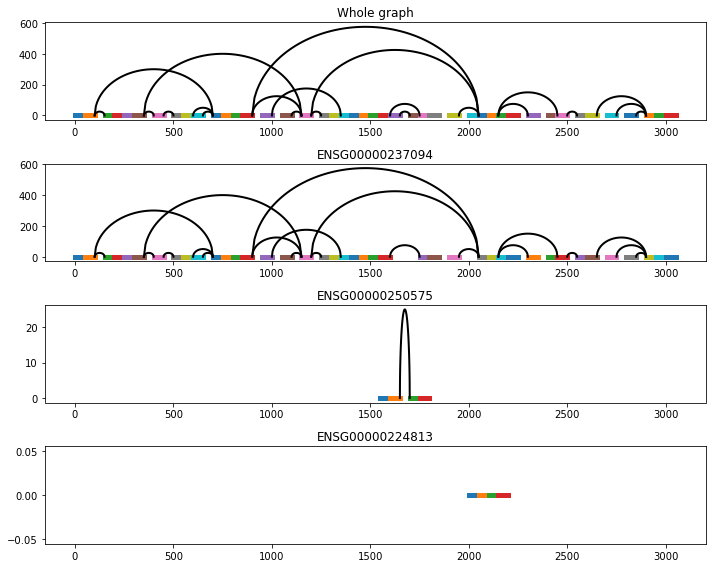

In [ ]:
pyplot.figure(figsize=(10,8))
ax=pyplot.subplot(411)
plotted_graph=plot_splice_graph(splice_graphs[7], simplify_distances=True)
pyplot.title('Whole graph')
gene_names=[k for k in splice_graphs[7].gene_dict.keys()]
for i in range(3):
    gene=gene_names[i]
    pyplot.subplot(412+i, sharex=ax)
    plotted_graph=plot_splice_graph(gene_subgraphs[gene],coordinate_mapper=plotted_graph.coordinate_mapper)
    pyplot.title(gene)
    
pyplot.tight_layout()


In [ ]:
transcript_subgraphs=splice_graphs[0].extract_transcript_subgraphs()

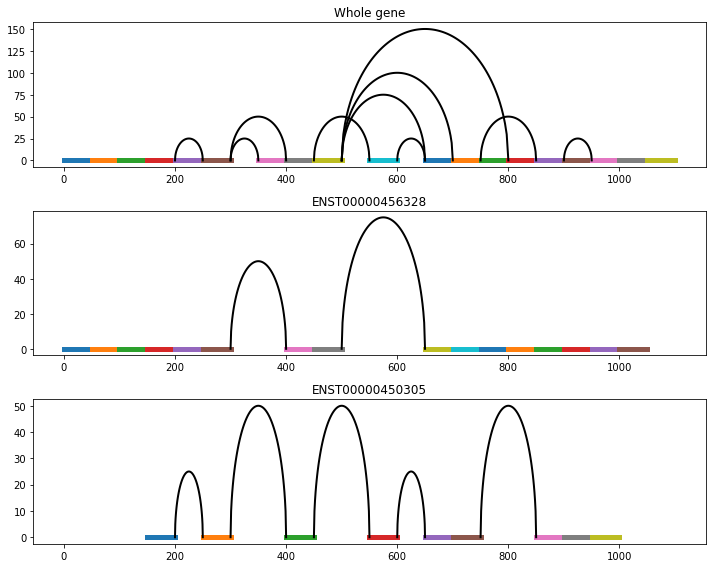

In [ ]:
pyplot.figure(figsize=(10,8))
ax=pyplot.subplot(311)
plotted_graph=plot_splice_graph(splice_graphs[0], simplify_distances=True)
pyplot.title('Whole gene')
pyplot.subplot(312, sharex=ax)
plotted_graph=plot_splice_graph(transcript_subgraphs['ENST00000456328'],coordinate_mapper=plotted_graph.coordinate_mapper)
pyplot.title('ENST00000456328')
pyplot.subplot(313, sharex=ax)
plotted_graph=plot_splice_graph(transcript_subgraphs['ENST00000450305'],coordinate_mapper=plotted_graph.coordinate_mapper)
pyplot.title('ENST00000450305')
pyplot.tight_layout()


In [ ]:
nodes=test.nodes
paths={}
for node,node_info in tqdm(nodes):
    paths[node]=len(test.enumerate_paths_anchored_in_node(node, 200, 'downstream', max_paths=100))

100%|██████████| 2/2 [00:00<00:00, 20919.22it/s]


In [ ]:
nodes=test.nodes
paths={}
for node,node_info in tqdm(nodes):
    paths[node]=len(test.enumerate_annotated_paths(node, 200, 'downstream'))

100%|██████████| 2/2 [00:00<00:00, 10318.09it/s]


In [ ]:
paths

{509246: 1, 509247: 1}

In [ ]:
len(paths)

2

In [ ]:
# G=splice_graphs[0]
G=splice_graphs[1].graph
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
print (edges)
color_dict={'exonic':'r', 'EEJ':'b'}
colors = [color_dict[G[u][v]['info'].kind] for u,v in edges]
print (colors)
# weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, edge_color=colors)

[(19, 23), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25)]
['b', 'r', 'r', 'r', 'b', 'r']


In [ ]:
splice_graphs[0]

In [ ]:
def test_whether_graph_is_chromosome_specific(graph, tx_segments):
    nodes=graph.nodes()
    chrom_set=set()
    for segment_id in nodes:
        chrom_set.add(tx_segments.segment_dict[segment_id].chrom)
    assert (len(chrom_set)==1)

        
def test_whether_all_splice_graphs_are_chromosome_specific(graphs, tx_segments):
    """Check whether all splice graphs are restricted to the same chromosome (they should be)"""
    failed=False
    for graph in graphs:
        try:
            test_whether_graph_is_chromosome_specific(graph.graph, tx_segments)
        except:
            failed=True
    assert failed==False
test_whether_all_splice_graphs_are_chromosome_specific(splice_graphs, tx_segments)

In [ ]:
def test_whether_splice_graph_is_strand_specific(graph, tx_segments):
    nodes=graph.nodes()
    strand_set=set()
    for segment_id in nodes:
        strand_set.add(tx_segments.segment_dict[segment_id].strand)
#     try:
    assert (len(strand_set)==1)
#     except:
#         print (strand_set)
def test_whether_all_splice_graphs_are_strand_specific(graphs,tx_segments):
    """Check whether all splice graphs are restricted to the same strand (they should be)"""
#     graphs=construct_splice_graphs(tx_segments)
    failed=0
    for graph in graphs:
        try:
            test_whether_splice_graph_is_strand_specific(graph.graph, tx_segments)
        except:
            failed+=1
            if failed<10:
                print ('graph nodes')
                for n in graph.nodes:
                    print (f"\n{tx_segments.segment_dict[n]}")
    print (failed)
    assert failed==0
test_whether_all_splice_graphs_are_strand_specific(splice_graphs, tx_segments)    


0


In [ ]:
# G.add_nodes_from(IDs)

In [ ]:
# edge_list=set()
# for tx in tx_structure:
#     ids=[]
#     for exon_seg in tx_structure[tx]:
#         interval, ID=exon_seg
#         ids.append(ID)
#     for i in range(len(ids)-1):
#         edge_list.add((ids[i],ids[i+1]))

In [ ]:
# subgraphs=[]
# for sg in tqdm(nx.components.connected_components(G)):
#     subgraphs.append(G.subgraph(sg).copy() )

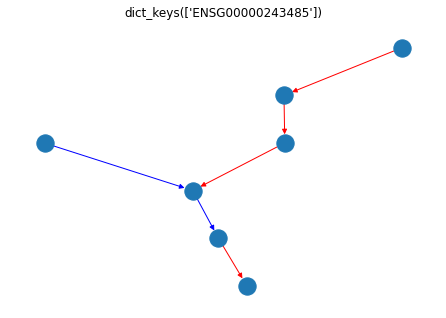

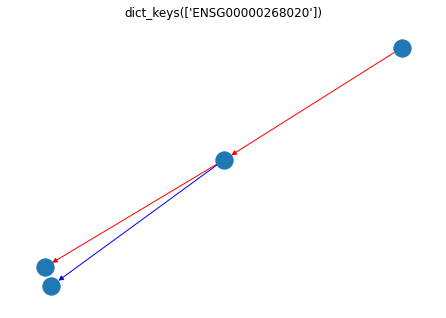

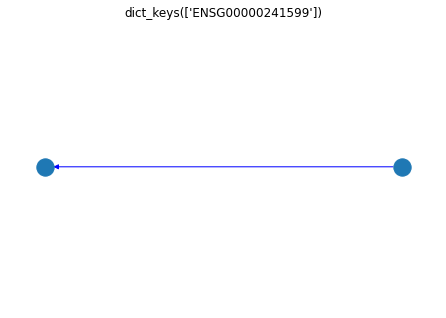

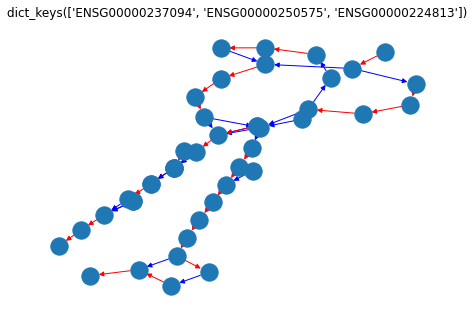

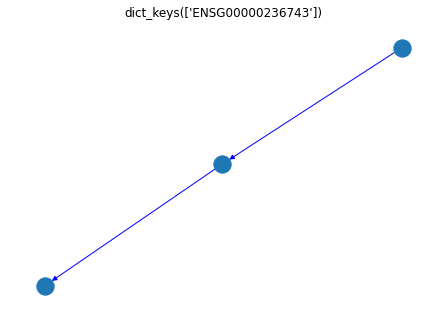

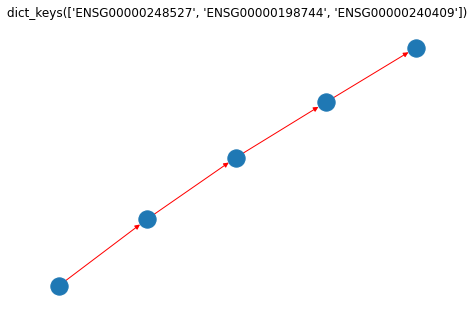

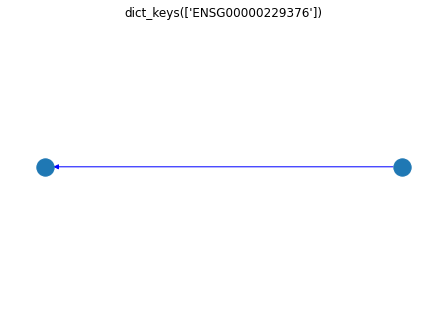

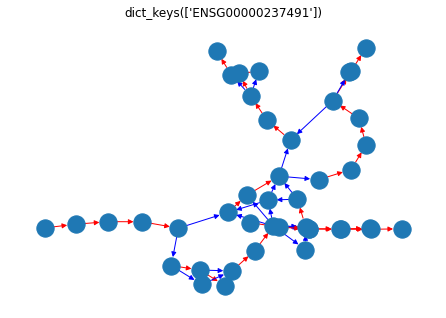

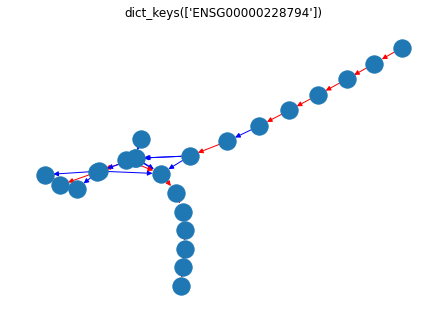

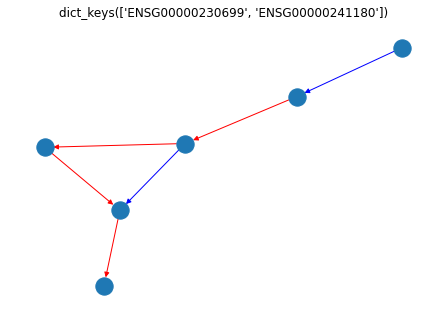

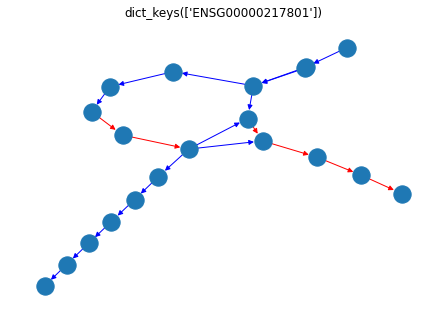

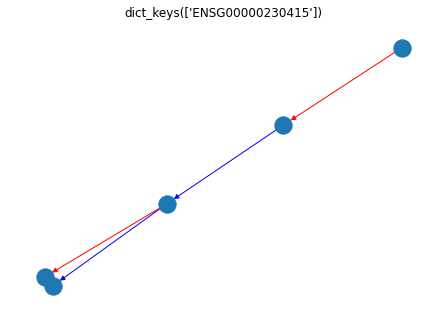

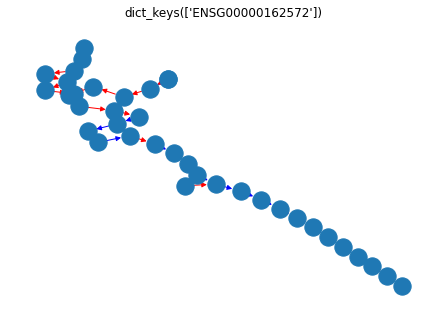

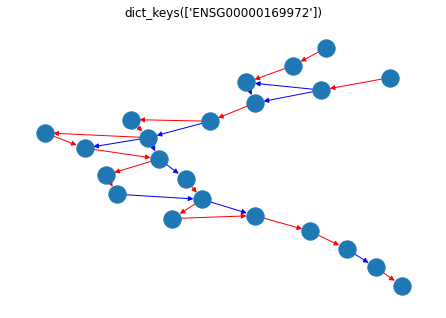

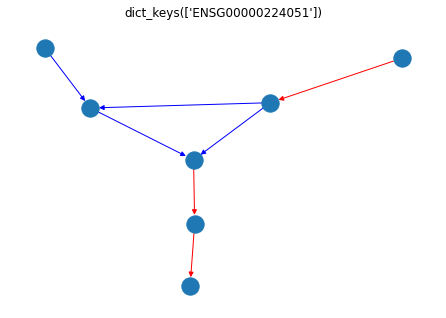

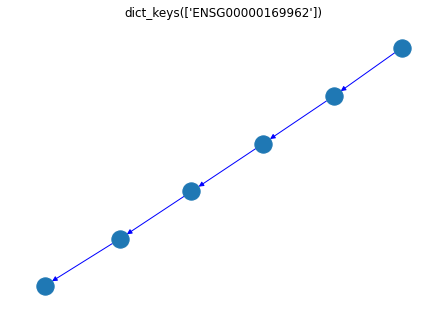

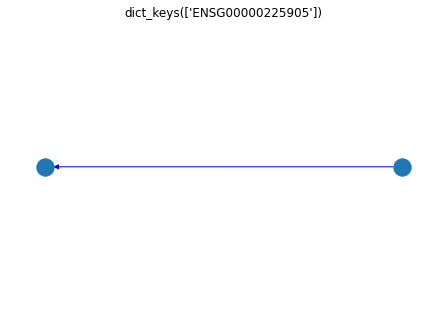

In [ ]:
for i in range(50):
    G=splice_graphs[i].graph
    pos = nx.kamada_kawai_layout(G)
    if len(G.nodes())==1: continue
    edges = G.edges()
    color_dict={'exonic':'r', 'EEJ':'b'}
    colors = [color_dict[G[u][v]['info'].kind] for u,v in edges]
    # weights = [G[u][v]['weight'] for u,v in edges]

    nx.draw(G, pos, edge_color=colors)
    pyplot.title(splice_graphs[i].gene_dict.keys())
    pyplot.show()

In [ ]:
# for i in range(10):
#     genes=set()
#     node_count=0
#     for n in splice_graphs[i].nodes:
# #         print (n)
# #         print (
#         node_count+=1
# #         for g in gene_col[n].split(','):
#         for g in tx_segments.segment_dict[n].gene_ids:
# #         for g in tx_segments.segment_dict[n].tx_ids:
#             genes.add(g)
#     if node_count==1: continue
#     print (genes)
# #     for g in tx_segments.segment_dict[n].gene_ids:
#     genes=set()
#     for n in splice_graphs[i].nodes:
#         for g in tx_segments.segment_dict[n].tx_ids:
#             genes.add(g)
#     print (sorted(genes))
#     digraph=nx.DiGraph()
#     digraph.add_nodes_from(splice_graphs[i].nodes)
#     digraph.add_edges_from(splice_graphs[i].edges)
#     nx.draw_kamada_kawai( digraph)

        
#     pyplot.show()

TypeError: unhashable type: 'dict'

## Visualizing the graphs

In [ ]:
from matplotlib.patches import FancyArrowPatch, Rectangle
def curvedarrow( start, end, rad=.5,lw=3):

    ax=pyplot.gca()
    style = f"Simple, tail_width=0.5, head_width={2*lw}, head_length={4*lw}"
    kw = dict(arrowstyle=style, color="k")
    patch=FancyArrowPatch(start, end,connectionstyle=f"arc3,rad={-1*rad}",lw=lw, **kw)
    pyplot.scatter([start[0], end[0]], [start[1], end[1]], alpha=0)
    ax.add_patch(patch)

fig=pyplot.figure()
curvedarrow([0,0], [10,0], .5)
curvedarrow([0,0], [5,0], .5)
# pyplot.xlim(-20,30)
# pyplot.ylim(0,15)

In [ ]:
def draw_bar(start, end,height=None,**kwargs):
    
    ylim=pyplot.ylim()
    if isinstance(height,type(None)):
        height=.075*(max(ylim)-min(ylim))
    ax=pyplot.gca()
    cx=start
    width=end-start
    cy=-height/2
    patch=Rectangle((cx,cy), width=width, height=height, **kwargs)
    pyplot.scatter([start, end], [-height, height], alpha=0.0)

    ax.add_patch(patch)

    

I want something that looks like this.

In [ ]:
curvedarrow([100,0.4], [250,0.5], .75)
curvedarrow([150,0.4], [250,0.5], -.75)
draw_bar(50,100, color='dodgerblue')
draw_bar(100,150, color='blue')
draw_bar(250,300, color='dodgerblue')

# pyplot.ylim(0,10)

The function should take a list of exon segments and a list of junctions between them.

In [ ]:
digraph.nodes

In [ ]:
[p for p in nx.all_simple_paths(digraph, 162, 44185)]

In [ ]:
seaborn.distplot(node_num)

The `SpliceGraph` class organizes a directed graph whose nodes are exon segments on the same strand and whose edges reflect that two segments are coterminous in at least one transcript. These edges follow a $5' \rightarrow 3'$ direction such that on the $+$ strand edges begin at the segment with smallest sequence coordinate and end at the segment with the greatest, and *vice versa* on the $-$ strand. Strictly speaking, a `SpliceGraph` may include information beyond splicing outcomes and includes alternative start and stop sites. 

A `SpliceGraph` therefore has the following attributes

A `SpliceGraph` should be able to map genomic coordinates to the constituent exon segments.

`.

In [ ]:
nodes=[0,1,2,3,4]
G=nx.Graph()
G.add_nodes_from(nodes)
edges=[(3,2),(2,1),(1,4),(2,0)]
G.add_edges_from(edges)

In [ ]:
G.edges()

In [ ]:
nodes=[0,1,2,3,4]
G=nx.DiGraph()
G.add_nodes_from(nodes)
edges=[(3,2),(2,1),(1,4),(2,0)]
G.add_edges_from(edges)

In [ ]:
G.edges()

I need a function that enumerate paths that begin at a node and move either forward or backwards along a transcript graph until the.

I want to do this recursively, but it will construct a big messy tree of lists.



In [ ]:
test=splice_graphs[0]
test.nodes
    

In [ ]:
test.enumerate_paths_anchored_in_node(5)

In [ ]:
test.enumerate_annotated_paths(5)

In [ ]:
# tx_graph.splice_graphs[47168].extract_transcript_subgraphs()

In [ ]:
sg=test.extract_transcript_subgraphs()

In [ ]:
for tx in sg:
    print (tx,sg[tx].enumerate_paths_anchored_in_node(5, max_len=300))

In [ ]:
test.transcript_dict

In [ ]:
sg['ENST00000456328'].gene_dict

In [ ]:
sg['ENST00000456328']

In [ ]:
test.extract_gene_subgraphs()

In [ ]:
sg['ENST00000450305'].nodes

In [ ]:
nx.draw_kamada_kawai(sg['ENST00000456328'].graph)

In [ ]:
sg['ENST00000456328'].nodes

In [ ]:
# sg=test.extract_gene_subgraphs()

In [ ]:
subnodes=sg['ENST00000450305'].transcript_dict['ENST00000450305']

In [ ]:
sg['ENST00000450305'].graph.subgraph(subnodes).nodes()

In [ ]:
for node in sg['ENST00000450305'].graph.subgraph(subnodes).nodes(data=True):
    print (node)

In [ ]:
sg['ENST00000450305'].graph.subgraph(subnodes).edges()

In [ ]:
nx.draw_kamada_kawai(sg['ENST00000450305'].graph.subgraph(subnodes))

In [ ]:
# test.segments.tx_structure['ENST00000450305']

In [ ]:
test.graph.edges()

In [ ]:
seq_set=[]
for edge in tqdm(test.graph.edges()):
    n1,n2=edge
    seq_ur=test.enumerate_sequences_anchored_in_node(n1, max_len=200, direction='upstream')
    seq_dr=test.enumerate_sequences_anchored_in_node(n2, max_len=200, direction='downstream')
    print (len(seq_ur), len(seq_dr))
    seq_set.append(combine_items(seq_ur,seq_dr))

In [ ]:
[len(s) for s in seq_set]

[2, 2, 5, 2, 8, 8, 8, 8, 8, 20, 4, 8, 8, 4, 4, 12, 3, 3, 3, 3, 1, 1, 1, 2, 1]

In [ ]:
test.strand

'+'

In [ ]:
# length=200
# [(s.count('G')+s.count('C'))/float(length) for s in test.enumerate_sequences_anchored_in_node(128, max_len=length, direction='downstream')]

In [ ]:
# length=200
# [(s.count('G')+s.count('C'))/float(length) for s in test.enumerate_sequences_anchored_in_node(126, max_len=length, direction='upstream')]

In [ ]:
res_u=test.enumerate_paths(5, max_len=200, direction='upstream')
res_d=test.enumerate_paths(6, max_len=200, direction='downstream')
combine_items([r[::-1] for r in res_u], res_d)

AttributeError: 'SpliceGraph' object has no attribute 'enumerate_paths'

In [ ]:
for res in res_d:
#     print (res)
    length=[]
#     len_list=[]
    seq=''
    for n in res:
        length.append(test.nodes[n]['info'].length)
        seq+=test.nodes[n]['info'].sequence
    print (length)
    print (sum(length))
    print ((seq[:200].count('G')+seq[:200].count('C'))/200.)

NameError: name 'res_d' is not defined

In [ ]:
res

NameError: name 'res' is not defined

In [ ]:
test.graph.subgraph(res[1]).edges(data=True)

NameError: name 'res' is not defined

In [ ]:
test.graph.subgraph(res[0]).edges(data=True)

NameError: name 'res' is not defined

In [ ]:
class PathEnumerator():
    def __init__(self,graph, node):

        self.results=[]
        self.node=node
        self.graph=graph
    def step_along_path(self,path, node):
        accessible_nodes=self.iterfunc(node)
        extended_paths=[]
        count=0
        for n in accessible_nodes:
            count+=1
            new_path=path+[n]
            extended_paths.append(self.step_along_path(new_path , n))
        if count==0:
            self.results.append(path)
        else:
            return extended_paths
    def enumerate_paths(self,direction='upstream' ):
        if direction=='upstream':
            self.iterfunc=self.graph.predecessors
        elif direction=='downstream':
            self.iterfunc=self.graph.successors
        else:
            raise ValueError("The `direction` argument must either be 'upstream' or 'downsteam' ")
        self.results=[]
        self.step_along_path([self.node],self.node )
        return self.results


In [ ]:
# test=PathEnumerator(splice_graphs[0], 5)
test.enumerate_paths()

AttributeError: 'SpliceGraph' object has no attribute 'enumerate_paths'

In [ ]:
def enumerate_paths( graph,node, direction='upstream'):
    if direction=='upstream':
        iterfunc=graph.predecessors
    elif direction=='downstream':
        iterfunc=graph.successors
    else:
        raise ValueError("The `direction` argument must either be 'upstream' or 'downsteam' ")
    
    res= step_along_path( node, iterfunc)
    if direction=
    

SyntaxError: invalid syntax (<ipython-input-93-5f643e3f25fd>, line 10)

In [ ]:
enumerate_paths(splice_graphs[0],5)

NameError: name 'enumerate_paths' is not defined

In [ ]:
splice_graphs[0].nodes(data=True)[5]

TypeError: 'NodeDataView' object is not callable

In [ ]:
def step_along_path( node, func,path=[], results=[]):
    if len(path)==0:
        path=[]
        results=[]
    accessible_nodes=func(node)
    extended_paths=[]
    count=0
    for n in accessible_nodes:
        count+=1
        new_path=path+[n]
#         print (new_path)
#         extended_paths.append([])
        results=(step_along_path( n, func,new_path , results))
    if count==0:
        results.append(path)
    return results
        
        
        

In [ ]:
# func=
step_along_path(5, splice_graphs[0].predecessors)

AttributeError: 'SpliceGraph' object has no attribute 'predecessors'

In [ ]:
[node for node in splice_graphs[0].predecessors(5)]

AttributeError: 'SpliceGraph' object has no attribute 'predecessors'

In [ ]:
[node for node in splice_graphs[0].predecessors(0)]

AttributeError: 'SpliceGraph' object has no attribute 'predecessors'

In [ ]:
test=SpliceGraph(digraph, tx_structure)

NameError: name 'digraph' is not defined

In [ ]:
node_list=[]
for n in test.graph.nodes:
    strand=tx_segments.segment_dict[n].strand
    node_list.append((n,tx_segments.segment_dict[n].start,tx_segments.segment_dict[n].end,
                     abs(tx_segments.segment_dict[n].start-tx_segments.segment_dict[n].end)))

In [ ]:
print (sorted_list)

In [ ]:
intron_len=200
exon_len=100
sorted_list=sorted(node_list, key=lambda x: x[1])
proxy_exons={}
for i in range(0,len(sorted_list)-1):

    node_id=sorted_list[i][0]
    length=sorted_list[i][3]
    if i==0:
        start=sorted_list[i][1]
    else:
        dist_to_last=sorted_list[i][1]-sorted_list[i-1][2]
        if dist_to_last>0:
            dist_to_last=intron_len
        start=proxy_exons[sorted_list[i-1][0]][1]+dist_to_last
    proxy_exons[node_id]=(start,start+length)
        
#     print (dist_to_next)
    

In [ ]:
intron_len=2000
exon_len=400
sorted_list=sorted(node_list, key=lambda x: x[1])
proxy_exons={}
for i in range(0,len(sorted_list)):

    node_id=sorted_list[i][0]
    length=exon_len
    if i==0:
        start=0
    else:
        dist_to_last=sorted_list[i][1]-sorted_list[i-1][2]
        if dist_to_last>0:
            dist_to_last=intron_len
        start=proxy_exons[sorted_list[i-1][0]][1]+dist_to_last
    proxy_exons[node_id]=(start,start+length)

In [ ]:
pyplot.figure(figsize=(15,5))
for i, edge in enumerate(test.graph.edges()):
    sign=1
    n1,n2=edge
    pos1=proxy_exons[n1][1]
    pos2=proxy_exons[n2][0]
    start=min([pos1,pos2])
    end=max([pos1,pos2])
    if (end-start)>20:
        curvedarrow([start,2000], [end,2000], sign*1)
    

cdict={0:'blue',
      1:'dodgerblue'}
for i,val in enumerate(proxy_exons.values()):
    start, end=val[0],val[1]
    draw_bar(start, end,color=cdict[i%2])
# pyplot.xlim(50000,80000)
    

NameError: name 'proxy_exons' is not defined

<Figure size 1080x360 with 0 Axes>

In [ ]:
nx.draw_kamada_kawai(test.extract_subgraph(44175,44185))

In [ ]:
paths=test.extract_all_paths_between(44175,44185)

In [ ]:
for n in paths[0]:
    
    print (tx_segments.segment_dict[n])

### TranscriptomeGraph

We can imagine the possible transcriptome as a collection of `SpliceGraphs`. We'll organize this as a class called a `TranscriptomeGraph` and this is the object we'll work with when analyzing sequencing data. In terms of organization object does two main things

1. It stores connected splice graphs
2. It assigns each exon segment to a single SpliceGraph (by adding a column to the table of exon segments)

It also organizes queries, by directing queries to the correct SpliceGraph. However, it will need to check whether a read pair maps only to a single SpliceGraph, and have some error/assertion handling for cases where this is not true.

In [ ]:
#export
class PathResults():
    def __init__(self, chrom, strand, 
                 pos5, pos3,
                res5, res3,
                graphid5, graphid3,
                paths ,distances):
        """An object  querying the graph"""
        self.chrom=chrom
        self.strand=strand
        self.pos_5prime=pos5
        self.pos_3prime=pos3
        
        if len (res5)>0:
            self.segment_5prime=res5[0][-1]
        else:
            self.segment_5prime=None
        if len (res3)>0:
            self.segment_3prime=res3[0][-1]
        else:
            self.segment_3prime=None
        self.graph_5prime=graphid5
        self.graph_3prime=graphid3
        
        self.both_in_exons=(len(res5)>0)&(len(res3)>0)
        self.both_in_same_graph=self.graph_3prime==self.graph_5prime

        if self.segment_5prime!=self.segment_3prime:
            self.paths=paths
        else:
            if self.segment_5prime!=None:
                self.paths=[[self.segment_5prime]]
            else:
                self.paths=[]
            
        self.paths_exist=len(self.paths)>0
        self.path_lengths=distances
        
    def __repr__(self):
        return str(self.paths)

In [ ]:
# vprint(Warning('Test'), False)

In [ ]:
class TranscriptomeLookupResult():
    def __init__(self,graph_id):
        """Stores the results returned when querying a TranscriptomeGraph to identify which """

In [ ]:
from spliceformats.alignments import get_junctions_from_blocks

In [ ]:
#export
class TranscriptomeGraph():
    def __init__(self,gtfpath='',genome_path='', annot=None,tx_segments=None, verbose=True):
        """An object for representing the set of possible transcripts as a set of SpliceGraphs.
        ****
        **Attributes:**
        splice_graphs (dict, items are SpliceGraphs): A dictionary storing the SpliceGraphs constructed from the annotations.

        position_lookup (nested dict, items are nlcs interval trees): A nested dictionary the stores interval trees indicating \
        which sequence coordinates correspond to which ExonSegment. The dictionary is keyed [chromosome][strand]. The interval \
        tree stores the id number of the exon segment.

        graph_lookup (dict): A dictionary that indicates with SpliceGraph a given ExonSegment belongs to. Keys are ExonSegment ids, \
        items are SpliceGraph ids.
        """
        assert (isinstance(tx_segments,type(None))&
               isinstance(annot,type(None))&
                (gtfpath==''))==False, "A gtfpath, PyRanges, and TranscriptomeSegments containing the transcript annotations must be provided"
        if genome_path!='': 
            Warning("A path to reference genome matching the annotations was not provided.\
            The sequences of transcripts cannot be returned")
                    
        if isinstance(tx_segments,type(None)):
            if isinstance(annot, type(None)):
                ens_annot=pr.read_gtf(gtfpath)
                exon_ind=ens_annot.df['Feature']=='exon'
                df=ens_annot.df[exon_ind==True]
                df=df.sort_values(by=['Chromosome','Start'])
                annot=pr.PyRanges(df)
            self.segments=TranscriptomeSegments(annot=annot, genome_path=genome_path)
        else:
            self.segments=tx_segments
                    
#         self.segments=tx_segments
#         self.
        vprint ('Constructing transcript graphs...', verbose)
        graph_list=construct_splice_graphs(self.segments)
        self.splice_graphs={}
        self.position_lookup={}
        self.interval_dict={}
        self.graph_lookup={}
        self.path_record={}
        
        vprint ('Building interval tree for lookups...', verbose)
        self.transcript2graphid={}
        self.gene2graphid={}
        for i,G in progbar(enumerate(graph_list), verbose):
#             graph_nodes=G.graph.nodes(data=True)
            self.splice_graphs[i]=G
            transcripts_in_graph=[tx for tx in G.transcript_dict.keys()]
            for tx in transcripts_in_graph:
#                 assert (tx in self.transcript2graphid), f"The transcript {tx} occurs in both the graphs {i} and {self.transcript2graphid{tx}}"
                if tx not in self.transcript2graphid:
                    self.transcript2graphid[tx]=[]
                self.transcript2graphid[tx].append(i)
                
            genes_in_graph=[tx for tx in G.gene_dict.keys()]
            for gene in genes_in_graph:
#                 assert (tx in self.transcript2graphid), f"The transcript {tx} occurs in both the graphs {i} and {self.transcript2graphid{tx}}"
                if gene not in self.gene2graphid:
                    self.gene2graphid[gene]=[]
                self.gene2graphid[gene].append(i)
        
            for exon_segment,segment_info in G.graph.nodes(data=True):
                self.graph_lookup[exon_segment]=i
#                 segment_details=self.segments.segment_dict[exon_segment]
#                 segment_details=graph_nodes[exon_segment]['info']
                segment_details=segment_info['info']
                chrom=segment_details.chrom
                if chrom not in self.interval_dict:
                    self.interval_dict[chrom]={'+':{'Start':[], 'End':[],'IDs':[] },
                                               '-':{'Start':[], 'End':[],'IDs':[] }}
                    
                strand=segment_details.strand
                start=segment_details.start
                end=segment_details.end
                self.interval_dict[chrom][strand]['Start'].append(int(start))
                self.interval_dict[chrom][strand]['End'].append(int(end))
                self.interval_dict[chrom][strand]['IDs'].append(exon_segment)
#         print ([k for  k in self.interval_dict.keys()])
        for chrom in self.interval_dict.keys():
            self.position_lookup[chrom]={}
            for strand in self.interval_dict[chrom].keys():
                starts=numpy.array(self.interval_dict[chrom][strand]['Start']).astype(int)
                ends=numpy.array(self.interval_dict[chrom][strand]['End']).astype(int)
                IDs=numpy.array(self.interval_dict[chrom][strand]['IDs']).astype(int)
                self.position_lookup[chrom][strand]=ncls.NCLS(starts=starts, ends=ends, ids=IDs)
        
    def get_splicegraphs_containing_transcript(self,tx_id):
        return [self.splice_graphs[graphid] for graphid in self.transcript2graphid[tx_id]]
    
    def get_splicegraphs_containing_gene(self,gene_id):
        return [self.splice_graphs[graphid] for graphid in self.gene2graphid[gene_id]]
    
    def get_splicegraphs_containing_position(self,chrom, strand, pos):
        """Return the SpliceGraphs that contain the specified coordidate in an ExonSegment
        
        ****
        **Arguments:**
        
        `chrom`: chromosome
        
        `strand`: strand
        
        `pos`: The position
        
        ****
        **Returns:**
        
        `results`: A list of SpliceGraphs"""
        pos_results=self.query_position(chrom, strand, pos)
        graphs=[]
        id_set=set()
        for res in pos_results:
            start, end, seg_id=res
            graph_id=self.graph_lookup[seg_id]
            id_set.add(graph_id)
        for graph_id in id_set:
            graphs.append(self.splice_graphs[graph_id])
        return graphs
    
    def get_splicegraphs_in_interval(self,chrom, strand, start, end):
        """Return the SpliceGraphs with ExonSegments in the specified interval
        
        ****
        **Arguments:**
        
        `chrom`: chromosome
        
        `strand`: strand
        
        `start`, `end`: The specified interval
        
        ****
        **Returns:**
        
        `results`: A list of SpliceGraphs"""
        pos_results=self.query_interval(chrom, strand,start, end)
        graphs=[]
        id_set=set()
        for res in pos_results:
            start, end, seg_id=res
            graph_id=self.graph_lookup[seg_id]
            id_set.add(graph_id)
        for graph_id in id_set:
            graphs.append(self.splice_graphs[graph_id])
        return graphs
    
    def get_segments_in_interval(self,chrom, strand, start, end):
        """Return the ExonSegments in the specified interval
        
        ****
        **Arguments:**
        
        `chrom`: chromosome
        
        `strand`: strand
        
        `start`, `end`: The specified interval
        
        ****
        **Returns:**
        
        `results`: A list of SpliceGraphs"""
        pos_results=self.query_interval(chrom, strand,start, end)
        segment_list=[]
        for res in pos_results:
            start, end, seg_id=res
            segment_list.append(self.segments.segment_dict[seg_id])

        return segment_list
#         pass
    def query_position(self, chrom, strand, pos):
        """Return information about the exon segment containing the specified position
        
        ****
        **Arguments:**
        
        `chrom`: chromosome
        
        `strand`: strand
        
        `pos`: The specified position
        
        ****
        **Returns:**
        
        `results`: A list of tuples (start, end, segment_id)"""
        #Does this handle strands correctly given Python's coordinate system?
        return [f for f in self.position_lookup[chrom][strand].find_overlap(pos, pos+1)]
        pass
    
    def query_interval(self, chrom, strand, start, end):
        """Return information about exon segments in the specified interval
        
        ****
        **Arguments:**
        
        `chrom`: chromosome
        
        `strand`: strand
        
        `start`, `end`: The specified interval
        
        ****
        **Returns:**
        
        `results`: A list of tuples (start, end, segment_id)"""
        return [f for f in self.position_lookup[chrom][strand].find_overlap(start, end)]
        pass
    
    def get_all_sequences_anchored_at_junction(self):
        """Given a junction between two exon segments, determine the sequences of all paths \
        of length `path_length` up- and downstream of the junction and return all combinations \
        of the sequences."""
        
        pass
    def get_annotated_sequences_anchored_at_junction(self):
        """Given a junction between two exon segments, determine the sequences of all annotated \
        paths of length `path_length` up- and downstream of the junction and return the sequences."""
    
        pass
    def get_junctions_in_read(self, read):
        """Given a read, find both the exon-exon and exonic (exon-internal) junctions between ExonSegments"""
        EEJ=read.get_splice_junctions()
        junction_list=[]
        strand=read.transcribed_strand
        mod_pos=0-1*(strand=='-')
        chrom=read.chrom
        for junction in EEJ:
            c,s, start, end=junction
            start=int(start)
            end=int(end)
            try:
                s1,e2,id1=self.query_position(c,strand,start+mod_pos)
                s2,e2,id2=self.query_position(c,strand,end+mod_pos)
            except: 
                continue
            if s=='+':
                n1,n2=id1,id2
            else:
                n1,n2=id2,id1
            junction_list.append(TranscriptJunction(kind='EEJ',
                                                    chrom=c,
                                                    strand=s,
                                                    start=start,
                                                    end=end,
                                                    segment_ids=(n1,n2)))
        

        for block in read.blocks:
            start,end=block
            segments_in_block=self.query_interval(chrom, strand, start, end)
            for i,segment in enumerate(range(len(segments_in_block)-1)):
                if strand=='+':
                    seg1,seg2=segments_in_block[i],segments_in_block[i+1]
                    start1,end1,id1=seg1
                    start2,end2,id2=seg2
                    junction=TranscriptJunction(kind='exonic',
                                                chrom=chrom,
                                                strand=strand,
                                                start=end1,
                                                end=start2,
                                                segment_ids=(id1,id2))
                else:
                    seg1,seg2=segments_in_block[i],segments_in_block[i+1]
                    start1,end1,id1=seg1
                    start2,end2,id2=seg2
                    junction=TranscriptJunction(kind='exonic',
                                                chrom=chrom,
                                                strand=strand,
                                                start=start2,
                                                end=end1,
                                                segment_ids=(id1,id2))
                junction_list.append(junction)
        return junction_list
                
                    
        
    def get_junctions_in_readpair(self, readpair):
        pass
    
    def paths_between_positions(self, chrom, strand, pos1, pos2):
        """Given a pair of coordinates on the same chromosome and strand, identify which (if any) \
        TranscriptGraph they belong to and, if possible, determine all paths between those coordinates.
        ****
        **Arguments:**
        
        chrom (str): The chromosome of the query
        strand (str, "+" or "-"): The strand of the query
        pos1 (int): The first sequence coordinate
        pos2 (int): The second sequence coordinate

        Note: The order of pos1 and pos2 does not matter, as the strand determines the direction \
        in which the paths must run-- 5' --> 3' 
        ****
        **Returns:**
        
        `PathResults` instance indicating whether paths could be found, why a path could not be found if so, \
        and the paths identified."""
        positions=[pos1, pos2]
        if strand=='+':
            pos5=min(positions)
            pos3=max(positions)
        else:
            pos5=max(positions)
            pos3=min(positions)
        res5=self.query_position(chrom, strand, pos5)
        res3=self.query_position(chrom, strand, pos3)
        paths=[]
        graph_id3=None
        graph_id5=None
        distances=[]
        if len (res5)>0 and len(res3)>0:
#             return []
            s,e,node_id5=res5[0]
            s,e,node_id3=res3[0]
            
            graph_id5=self.graph_lookup[node_id5]
            graph_id3=self.graph_lookup[node_id3]
#             print (graph_id5, graph_id3)
            if graph_id5==graph_id3:
                distances=[]
                paths=self.splice_graphs[graph_id5].extract_all_paths_between(node_id5, node_id3, cutoff=20)
                for path in paths:
                    num_nodes=len(path)
                    distances.append(0)
                    if len(path)>1:
                        for i,node in enumerate(path):
                            if i==0:
                                if strand=='+':
                                    dist=abs(self.segments.segment_dict[node].end-pos5)
                                elif strand=='-':
                                    dist=abs(pos5-self.segments.segment_dict[node].start)
                            elif i==num_nodes-1:
                                if strand=='+':
                                    dist=abs(pos3-self.segments.segment_dict[node].start)
                                elif strand=='-':
                                    dist=abs(pos3-self.segments.segment_dict[node].end)
                            else: dist=abs(self.segments.segment_dict[node].end-self.segments.segment_dict[node].start)
                            distances[-1]+=dist
                    else:
                        distances[-1]=abs(pos3-pos5)
                if distances==[]:
                    distances.append(abs(pos3-pos5))
                    
                                
        return PathResults(chrom=chrom, strand=strand,
                          pos5=pos5, pos3=pos3,
                          res5=res5,res3=res3,
                          graphid5=graph_id5, graphid3=graph_id3,
                          paths=paths,
                          distances=distances)
    

In [ ]:
isinstance(tx_segments, type(None))

False

In [ ]:
tx_graph=TranscriptomeGraph(tx_segments=tx_segments)

Constructing transcript graphs...


57039it [00:08, 6623.07it/s] 
100%|██████████| 57039/57039 [00:03<00:00, 17431.40it/s]
17611it [00:00, 88418.51it/s]

Building interval tree for lookups...


57039it [00:03, 17909.24it/s]


In [ ]:
tx_ids=[k for k in tx_graph.transcript2graphid.keys()]

In [ ]:
tx_graph.segments.segment_dict[0]

chr1 (+): 11868-11871

In [ ]:
tx_graph.query_interval('chr1', '+', 11870,12008)

[(11868, 11871, 0), (11871, 11873, 1), (11873, 12009, 2)]

In [ ]:
num_graphs=[len(k) for k in tx_graph.transcript2graphid.values()]

In [ ]:
odd_tx=[]
for k in tx_ids:
    if len(tx_graph.transcript2graphid[k])>1:
        odd_tx.append((k,tx_graph.transcript2graphid[k] ))

In [ ]:
len(odd_tx)

0

In [ ]:
graph_keys=[k for k in tx_graph.splice_graphs.keys()]

In [ ]:
def plot_splice_graph(G):

    pos = nx.kamada_kawai_layout(G)

    edges = G.edges()

    color_dict={'exonic':'r', 'EEJ':'b'}
    colors = [color_dict[G[u][v]['info'].kind] for u,v in edges]

    nx.draw(G, pos, edge_color=colors)

dict_keys(['ENSG00000223972'])


dict_keys(['ENSG00000243485'])


dict_keys(['ENSG00000237094', 'ENSG00000250575', 'ENSG00000224813'])


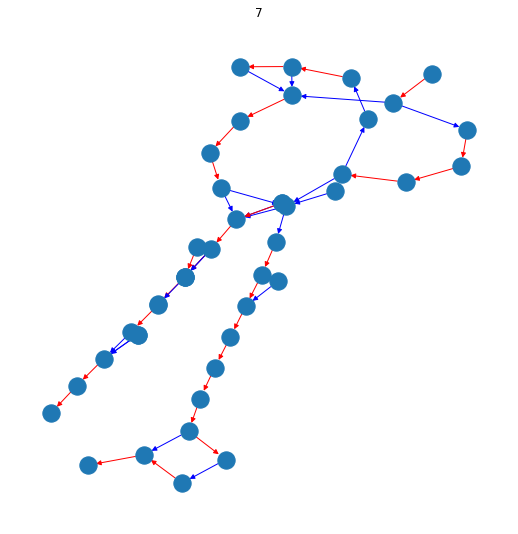

dict_keys(['ENSG00000235146'])


dict_keys(['ENSG00000248527', 'ENSG00000198744', 'ENSG00000240409'])


dict_keys(['ENSG00000237491'])


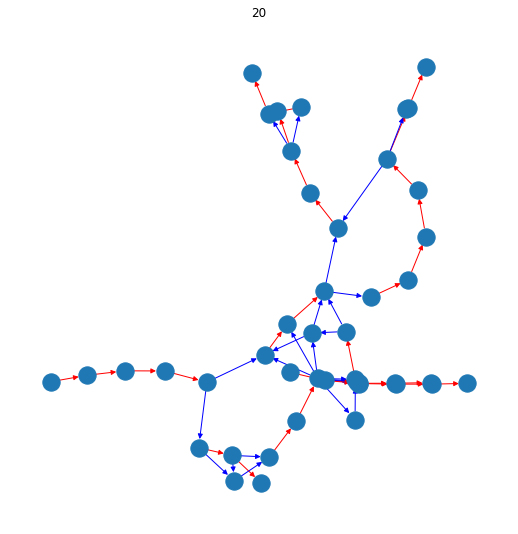

dict_keys(['ENSG00000228794'])


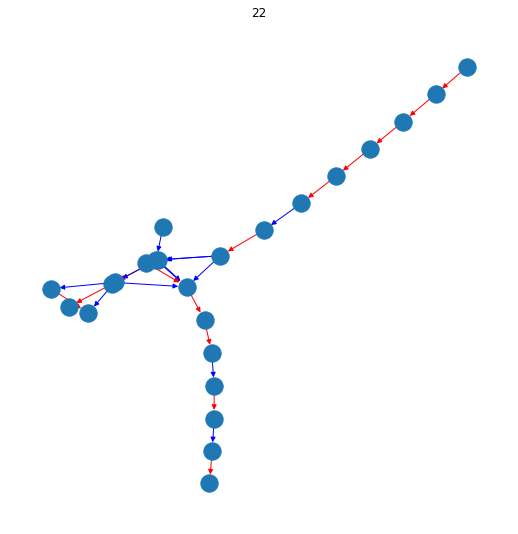

dict_keys(['ENSG00000230699', 'ENSG00000241180'])


dict_keys(['ENSG00000187634'])


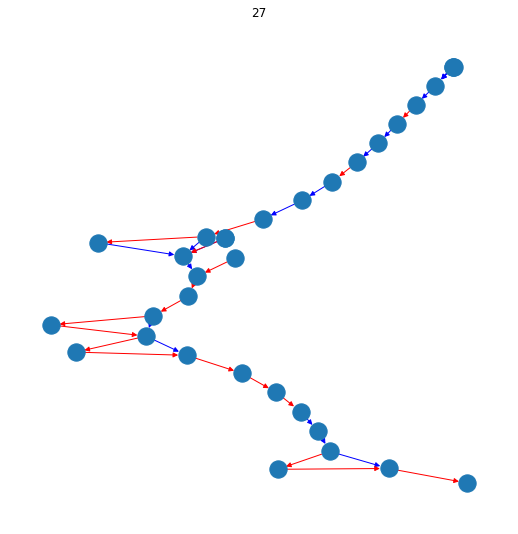

dict_keys(['ENSG00000187961'])


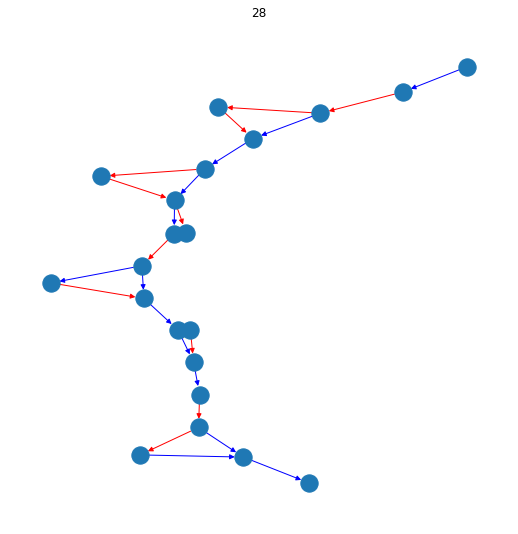

dict_keys(['ENSG00000187583'])


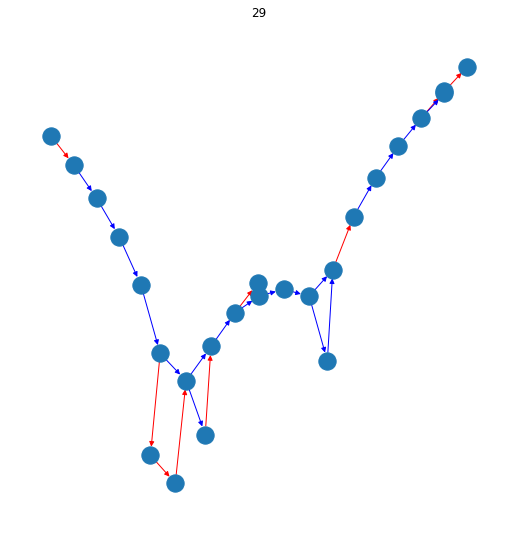

In [ ]:
for i,k in enumerate(graph_keys[:30]):
    g=tx_graph.splice_graphs[k].graph
    if len(g.nodes())<5: continue
#     nx.draw_kamada_kawai(g)
    print (tx_graph.splice_graphs[k].gene_dict.keys())
    pyplot.figure(figsize=(7,7))
    plot_splice_graph(g)
    pyplot.title(i)
    pyplot.show()
    
    
    

In [ ]:
jxn_keys=[k for k in jxn_dict.keys()]
print (jxn_keys[0])
# jxn_dict[keys[0]].read1

NameError: name 'jxn_dict' is not defined

In [ ]:
jxn_dict[jxn_keys[0]][0].transcribed_strand

NameError: name 'jxn_dict' is not defined

In [ ]:
jxn_dict[jxn_keys[0]][0].read1.get_splice_junctions()

In [ ]:
tx_graph.query_position('chr1', '-', 536957-1)

In [ ]:
tx_graph.query_position('chr1', '-', 536957-1)

In [ ]:
rp_list=[]
for k in tqdm(jxn_keys):
#     print (k)
    rp_list+=jxn_dict[k]
#     for rp in 

In [ ]:
res_list=[]
for rp in tqdm(rp_list):
#     print (k)
#     readpair=jxn_dict[k][0]
    for r in [rp.read1, rp.read2]:
#         print (f'\t{tx_graph.get_junctions_in_read(r)}')
        res_list.append(tx_graph.get_junctions_in_read(r))

In [ ]:
for r in res_list[:200]:
    if len(r)>0:
        print (r)

In [ ]:
import pysam
res_list=[]
fname="/home/mpm289/projects/SplicingMapAnalyses/00_data/00_RNAi/aligned_reads/TIA1_K562/kd/ENCFF425JBA.bam"
handle=pysam.AlignmentFile(fname)
read_dict={}
for read in tqdm(handle):
#     read=next(handle)
    if read.is_secondary==True: continue
    simp_read=SimplifiedAlignedRead(read)
    try:
#         res_list.append()
        res=tx_graph.get_junctions_in_read(simp_read)
    except:
        continue
    if len(res)>0:
        res_list.append(res)

In [ ]:
res_list[1][0].segment_ids

In [ ]:
[r.segment_ids for r in res_list[0]]

In [ ]:
res_list=[]
for k in tqdm(jxn_keys[:100000]):
#     print (k)
    readpair=jxn_dict[k][0]
#     for rp in 
    for r in [readpair.read1, readpair.read2]:
#         print (f'\t{tx_graph.get_junctions_in_read(r)}')
        res_list.append(tx_graph.get_junctions_in_read(r))

In [ ]:
res_list[0][0].segment_ids

In [ ]:
tx_graph.segments.tx_structure['']

In [ ]:
len(tx_graph.splice_graphs)

In [ ]:
tx_graph.splice_graphs[1].nodes

In [ ]:
tx_graph.splice_graphs[1].nodes[19]['info']

In [ ]:
tx_graph.splice_graphs[0].enumerate_paths_anchored_in_node(5,max_paths=100)

In [ ]:
tx_graph.splice_graphs[0].nodes[0]

In [ ]:
tx_graph.query_position('chr1', '+', 11869)

In [ ]:
seq_sets={}
graph_keys=[k for k in tx_graph.splice_graphs.keys()]
for key in tqdm(graph_keys):
    seq_sets[key]={'edge':[], 'number':[]}
    G=tx_graph.splice_graphs[key]
    for edge in (G.graph.edges()):
        n1,n2=edge
        seq_ur=G.enumerate_paths_anchored_in_node(n1, max_len=200, direction='upstream', max_paths=10)
        seq_dr=G.enumerate_paths_anchored_in_node(n2, max_len=200, direction='downstream', max_paths=10)
        seq_sets[key]['edge'].append((n1,n2))    
        seq_sets[key]['number'].append(len(combine_items(seq_ur,seq_dr)))

In [ ]:
G_id=[]
max_count=[]
for key in seq_sets.keys():
    G_id.append(key)
    if len(seq_sets[key]['number'])>0:
        max_count.append(max(seq_sets[key]['number']))
    else:
        max_count.append(0)

In [ ]:
numpy.argmax(max_count)

In [ ]:
G_id[7616]

In [ ]:
tx_graph.splice_graphs[7616].gene_dict

In [ ]:
tx_graph.splice_graphs[7616].strand

In [ ]:
# pyplot.figure(figsize=(30,30))
# nx.draw_circular(tx_graph.splice_graphs[7616].graph)

In [ ]:
genes=set()
tx=set()
for node, node_info in tx_graph.splice_graphs[47168].nodes:
    genes|=set(node_info['info'].gene_ids)
    tx|=set(node_info['info'].tx_ids)
#     print (node)

In [ ]:
tx

In [ ]:
for n1,n2, edge_info in tx_graph.splice_graphs[47168].graph.edges(data=True):
#     genes|=set(node_info['info'].gene_ids)
    print (edge_info)

In [ ]:
for node, node_info in tx_graph.splice_graphs[47168].nodes:
#     genes|=set(node_info['info'].gene_ids)
    print (node_info)

In [ ]:
genes

In [ ]:
from collections import Counter

In [ ]:
Counter(seq_sets)

In [ ]:
seaborn.distplot(seq_sets)

In [ ]:
# tx_graph.segments.exon_edges

In [ ]:
[f for f in tx_graph.position_lookup['chr1']['+'].find_overlap(12000,12500)]

In [ ]:
#92169, 237932
#chr1:18366-24737
#17683 18002
pos1,pos2=1192686, 1203275
# pos1,pos2=1158718, 1163858
s,e,nid1=tx_graph.query_position('chr1', '-', pos1)[0]
tx_graph.graph_lookup[nid1]
s,e,nid2=tx_graph.query_position('chr1', '-', pos2)[0]
s_id=tx_graph.graph_lookup[nid2]

In [ ]:
s_idid

In [ ]:
nx.draw_kamada_kawai(tx_graph.splice_graphs[3353].graph)

In [ ]:
for n in tx_graph.splice_graphs[3353].nodes:
    print (n)

In [ ]:
tx_graph.splice_graphs[3353].enumerate_paths_anchored_in_node(27999, max_len=200, direction='downstream')

In [ ]:
tx_graph.splice_graphs[3353].enumerate_sequences_anchored_in_node(27999, max_len=200, direction='downstream')

In [ ]:
paths=tx_graph.paths_between_positions('chr1', '-', pos2,pos1)

In [ ]:
paths

In [ ]:
paths.path_lengths

In [ ]:
s,e,nid2=tx_graph.query_position('chr1', '-', pos2)[0]
s_id=tx_graph.graph_lookup[nid2]

In [ ]:
paths=tx_graph.splice_graphs[s_id].extract_all_paths_between(nid1,nid2)

In [ ]:
paths

In [ ]:
for i,path in enumerate(paths):
    print (f'Path {i}')
    length=0
    for exon in path:
        print (f'\t {tx_segments.segment_dict[exon]}')
        length+=abs(tx_segments.segment_dict[exon].end-tx_segments.segment_dict[exon].start)
    print (f'\t Length = {length}')
    

In [ ]:
# nx.draw_kamada_kawai(tx_graph.splice_graphs[2139].extract_subgraph(nid1-1,nid2+1))

In [ ]:
tx_graph.segments.segment_dict[24737]

In [ ]:
tx_graph.graph_lookup[24632]

In [ ]:
tx_graph.query_position('chr1', '-', 24737)

In [ ]:
tx_graph.segments.segment_dict[27636]

In [ ]:
tx_graph.graph_lookup[27636]

In [ ]:
tx_graph.splice_graphs[6770].graph.nodes()

In [ ]:
print (tx_graph.graph_lookup[27651])
print (tx_graph.graph_lookup[27694])

In [ ]:
import pickle
from spliceformats.alignments import SimplifiedAlignedRead, ReadPair
with open('02_testing/junction_reads_for_tests.pckl',mode='rb') as handle:
    jxn_dict=pickle.load(handle)

In [ ]:
keys=[k for k in jxn_dict.keys()]

In [ ]:
print (keys[50:100])
# print (keys[0:20])

In [ ]:
key= 'chr1,+,228643,231836'
key='chr1,-,17364,17497'
key='chr10,+,75842302,75843123'
jxn_dict[key][0].read1.cigarstring

In [ ]:
read_start=jxn_dict[ key][0].read1.start
read_end=jxn_dict[ key][0].read1.end
print (read_start, read_end)

In [ ]:
paths=tx_graph.paths_between_positions('chr10', '+',read_start, read_end)

In [ ]:
paths.paths

In [ ]:
paths.path_lengths

In [ ]:
tx_seq=''
for i, n in enumerate(paths.paths[0]):
    if i==0:
        seq=tx_segments.segment_dict[n].get_sequence(start=read_start)
    elif i==len(paths.paths[0])-1:
        seq=tx_segments.segment_dict[n].get_sequence(end=read_end)
    else:
        seq=tx_segments.segment_dict[n].sequence
#     print (seq)
    tx_seq+=seq
print (tx_seq)

In [ ]:
print (jxn_dict[ key][0].read1.query_sequence)

In [ ]:
key= 'chr1,+,228643,231836'
key='chr1,-,17364,17497'
key='chr1,-,70621479,70625012'
for r in jxn_dict[key]:
    print (r.read1.cigarstring)

In [ ]:
read_start=jxn_dict[ key][1].read2.start
read_end=jxn_dict[ key][1].read2.end
print (read_start, read_end)

In [ ]:
jxn_dict[ key][1].read2.cigarstring

In [ ]:
paths=tx_graph.paths_between_positions('chr1', '-',read_end, read_start)

In [ ]:
read_count=0
read_paths={}
for jxn in tqdm(jxn_dict):
    chrom,strand,end1,end2=jxn.split(',')
    read_paths[jxn]=[]
#     print (len(jxn_dict[jxn]))
    for readpair in (jxn_dict[jxn]):
        read_paths[jxn].append([])
        for read in [readpair.read1, readpair.read2]:
            if read.cigarstring.find('N')==0: continue
            
            read_count+=1
            read_start=read.start
            read_end=read.end
    # for i in tqdm(range(100000)):
#             read_paths[jxn][-1].append(tx_graph.paths_between_positions(read.chrom, read.transcribed_strand,read_end, read_start))
            path=tx_graph.paths_between_positions(chrom, '+',read_end, read_start)
            if path.paths_exist==False:
                path=tx_graph.paths_between_positions(chrom, '-',read_end, read_start)
                
            read_paths[jxn][-1].append(path)

In [ ]:
read_count=0
read_paths={}
for jxn in tqdm(jxn_dict):
    chrom,strand,end1,end2=jxn.split(',')
    read_paths[jxn]=[]
#     print (len(jxn_dict[jxn]))
    for readpair in (jxn_dict[jxn]):
#         break
        if readpair.overlap>0: continue
        read_paths[jxn].append([])
        
#         for read in [readpair.read1, readpair.read2]:
#             if read.cigarstring.find('N')==0: continue
            
        read_count+=1
        read_start=readpair.read1.pos3
        read_end=readpair.read2.pos3
# for i in tqdm(range(100000)):
#             read_paths[jxn][-1].append(tx_graph.paths_between_positions(read.chrom, read.transcribed_strand,read_end, read_start))
#         path=tx_graph.paths_between_positions(chrom, '+',read_end, read_start)
#         path=tx_graph.paths_between_positions(chrom, readpair.transcribed_strand ,read_end, read_start)
        path=tx_graph.paths_between_positions(chrom, strand ,read_end, read_start)

#         if path.paths_exist==False:
#             path=tx_graph.paths_between_positions(chrom, '-',read_end, read_start)

        read_paths[jxn][-1].append(path)

In [ ]:
readpair.overlap

In [ ]:
read_count

In [ ]:
exists_count=0
for jxn in read_paths:
    for readpair in read_paths[jxn]:
        for path in readpair:
            exists_count+=path.both_in_same_graph

In [ ]:
exists_count

In [ ]:
exists_count=0
for jxn in read_paths:
    for readpair in read_paths[jxn]:
        break_iter=False
        for path in readpair:
            exists_count+=path.both_in_exons
            if path.both_in_exons==False:
                break_iter=True
#         if break_iter==True: break
exists_count

In [ ]:
exists_count=0
for jxn in read_paths.keys():
    for readpair in read_paths[jxn]:
#         print (read_paths[jxn])
#         print (jabber)
        break_iter=False
        for path in readpair:
            exists_count+=path.paths_exist*1.
            if path.paths_exist==False:
                break_iter=False
        if break_iter==True: 
#             print ('stop')
            break
    if break_iter==True: 
        print ('stop')
        break
exists_count

In [ ]:
path_lengths=[]
paths=[]
for jxn in read_paths.keys():
    for readpair in read_paths[jxn]:
#         print (read_paths[jxn])
#         print (jabber)
        break_iter=False
        for path in readpair:
#             exists_count+=path.paths_exist*1.
            paths.append(path)
            if path.paths_exist==False:
                path_lengths.append(0)
            path_lengths.append(len(path.paths))
    

In [ ]:
set(path_lengths)

In [ ]:
[len(p) for p in paths[numpy.argmax(path_lengths)].paths]

In [ ]:
 paths[numpy.argmax(path_lengths)].path_lengths

In [ ]:
 paths[numpy.argmax(path_lengths)].pos_3prime

In [ ]:
 paths[numpy.argmax(path_lengths)].pos_5prime

In [ ]:
path_lengths[numpy.argmax(path_lengths)]

In [ ]:
exists_count

In [ ]:
jxn

In [ ]:
tx_graph.query_position(path.chrom,'+', path.pos_3prime)

In [ ]:
tx_graph.query_position(path.chrom,'+', path.pos_5prime)

In [ ]:
path.pos_3prime

In [ ]:
path.pos_5prime

I want to try reconstructing these reads

In [ ]:
readpair.transcribed_strand

In [ ]:
readpair.read1.pos5

In [ ]:
readpair.read2.pos5

In [ ]:
read_count=0
read_seq=[]
for jxn in tqdm(jxn_dict):
    chrom,strand,end1,end2=jxn.split(',')
#     read_seq[jxn]=[]
#     print (len(jxn_dict[jxn]))
    for readpair in (jxn_dict[jxn]):
#         break
        if readpair.overlap>0: 
            if readpair.transcribed_strand=='+':
                seq=len(readpair.read2.query_sequence[:-readpair.overlap])+len(readpair.read1.query_sequence)
            else:
                seq=len(readpair.read1.query_sequence[:-readpair.overlap])+len(readpair.read2.query_sequence)
            read_seq.append(seq)
            continue
        read_paths[jxn].append([])
        
#         for read in [readpair.read1, readpair.read2]:
#             if read.cigarstring.find('N')==0: continue
            
        read_count+=1
        read_start=readpair.read1.pos3
        read_end=readpair.read2.pos3
# for i in tqdm(range(100000)):
#             read_paths[jxn][-1].append(tx_graph.paths_between_positions(read.chrom, read.transcribed_strand,read_end, read_start))
#         path=tx_graph.paths_between_positions(chrom, '+',read_end, read_start)
#         path=tx_graph.paths_between_positions(chrom, readpair.transcribed_strand ,read_end, read_start)
        path=tx_graph.paths_between_positions(chrom, strand ,read_end, read_start)
        if len(path.paths)==0: continue
        if path.paths_exist==False: continue
        try:
            
            seq=len(readpair.read2.query_sequence)+len(readpair.read1.query_sequence)+path.path_lengths[0]
        except:
            print (path.path_lengths)
            print (path.paths)
            print (path.paths_exist)
            print (jabber)
    
#         if path.paths_exist==False:
#             path=tx_graph.paths_between_positions(chrom, '-',read_end, read_start)
        read_seq.append(seq)
#         read_paths[jxn][-1].append(path)

In [ ]:
read_count=0
read_seq={}
multipath={}
paths_exist={}
read_paths={}
min_read={}
max_read={}
for jxn in tqdm(jxn_dict):
    chrom,strand,end1,end2=jxn.split(',')
    read_seq[jxn]=[]
    multipath[jxn]=False
    read_paths[jxn]=set()
    max_read[jxn]=-numpy.inf
    min_read[jxn]=numpy.inf
    paths_exist[jxn]=False
#     print (len(jxn_dict[jxn]))
    for readpair in (jxn_dict[jxn]):
#         break
        if readpair.overlap>0: 
            if readpair.transcribed_strand=='+':
                seq=len(readpair.read2.query_sequence[:-readpair.overlap])+len(readpair.read1.query_sequence)
            else:
                seq=len(readpair.read1.query_sequence[:-readpair.overlap])+len(readpair.read2.query_sequence)
            read_seq[jxn].append(seq)
            continue
#         read_paths[jxn].append([])
        
#         for read in [readpair.read1, readpair.read2]:
#             if read.cigarstring.find('N')==0: continue
            
        read_count+=1
        read_start=readpair.read1.pos5
        read_end=readpair.read2.pos5
# for i in tqdm(range(100000)):
#             read_paths[jxn][-1].append(tx_graph.paths_between_positions(read.chrom, read.transcribed_strand,read_end, read_start))
#         path=tx_graph.paths_between_positions(chrom, '+',read_end, read_start)
#         path=tx_graph.paths_between_positions(chrom, readpair.transcribed_strand ,read_end, read_start)
        path=tx_graph.paths_between_positions(chrom, strand ,read_end, read_start)
        if len(path.paths)==0: continue
        if len(path.paths)>1: multipath[jxn]=True
        if path.paths_exist==False: continue
        try:
            
#             seq=len(readpair.read2.query_sequence)+len(readpair.read1.query_sequence)+path.path_lengths[0]
            seq=path.path_lengths[0]
        except:
            print (path.path_lengths)
            print (path.paths)
            print (path.paths_exist)
            print (jabber)
    
#         if path.paths_exist==False:
#             path=tx_graph.paths_between_positions(chrom, '-',read_end, read_start)
        read_seq[jxn].append(seq)
        paths_exist[jxn]=True
        if min([read_start, read_end])<min_read[jxn]:
            min_read[jxn]=min([read_start, read_end])
        if max([read_start, read_end])>min_read[jxn]:
            max_read[jxn]=max([read_start, read_end])
        for p in path.paths:
            read_paths[jxn].add(tuple(p))

In [ ]:
for jxn in read_seq:
    read_seq[jxn]=numpy.array(read_seq[jxn])

In [ ]:
jxn_keys=[key for key in multipath.keys()]

In [ ]:
read_paths[jxn_keys[120]]

In [ ]:
mp=[]
for k in jxn_keys[:200]:
    mp.append(multipath[k])

In [ ]:
numpy.mean(mp)

In [ ]:
all_len=[]
total=0
simple=0
for i,jxn in enumerate(read_seq.keys()):
    chrom,strand,s1,s2=jxn.split(',')

#     print (read_paths[jxn])
    if len(read_seq[jxn])<50: continue
    if paths_exist[jxn]==False: continue
    total+=1

    if multipath[jxn]==True: continue
    simple+=1

    try:
        print (len(tx_graph.paths_between_positions(chrom, strand, int(min_read[jxn]),int(max_read[jxn])).paths))
    except:
        pass
    

#     for p in read_paths[jxn]:
#         if p==[]: path_set.add('')
#         else: path_set.add(','.join([str(x) for x in p.paths[0]]))
# #     print (set([','.join(p[0]) for p in read_paths[jxn] ]))
#     print (path_set)
#     print (jabber)
#     if (read_seq[jxn]>300).mean()>.2: continue
    seaborn.ecdfplot(read_seq[jxn])
    all_len+=list(read_seq[jxn])
    pyplot.xlim(0,600)
#     pyplot.show()
#     if i>200: break

In [ ]:
total

In [ ]:
simple

In [ ]:
seaborn.ecdfplot(all_len)
pyplot.xlim(100,400)

In [ ]:
seaborn.distplot(all_len, kde=False)


In [ ]:
tx_graph.query_position(path.chrom,'+', path.pos_3prime)

In [ ]:
tx_graph.paths_between_positions(path.chrom, '+', path.pos_5prime, path.pos_3prime).paths_exist

In [ ]:
path.pos_3prime

In [ ]:
path.paths

In [ ]:
path.pos_5prime

In [ ]:
path.strand

In [ ]:
readpair

In [ ]:
jxn

In [ ]:
path.strand
tx_graph.query_position(path.chrom, '+', path.pos_3prime)

In [ ]:
tx_graph.query_position('chr1','-',read_end)

In [ ]:
tx_graph.subgraphs[21711]

In [ ]:
paths.paths

In [ ]:
print (tx_graph.segments.segment_dict[38360])
print (read_end)

In [ ]:
print (tx_graph.segments.segment_dict[38361])
print (read_start)

In [ ]:
paths.path_lengths

In [ ]:
tx_seq=''
seq_list=[]
for i, n in enumerate(paths.paths[0]):
    if i==0:
        seq=tx_segments.segment_dict[n].get_sequence(end=read_end)
        print (read_end)
        print  (tx_segments.segment_dict[n].start,tx_segments.segment_dict[n].end )
    elif i==len(paths.paths[0])-1:

        seq=tx_segments.segment_dict[n].get_sequence(start=read_start)
        print (read_start)
        print  (tx_segments.segment_dict[n].start,tx_segments.segment_dict[n].end )
    else:
        seq=tx_segments.segment_dict[n].sequence
    print (seq)
    seq_list.append(tx_segments.segment_dict[n].sequence)
    tx_seq+=seq
print ((tx_seq))

In [ ]:
seq_list[0][-50:] +seq_list[1][:50]

In [ ]:
seq_list[1][:50] +seq_list[0][:50]

In [ ]:
def complement(seq):
    """Complement a DNA sequence. Note characters other than A,T,G,C will be ignored
        Arguments:
            seq (str): the sequence
        Returns:
            complement (str): The complement of the sequence"""
    basepairs={'A':'T',
              'G':'C'}
    seq_array=numpy.fromiter(seq.upper(), 'U1')
    comp_array=numpy.copy(seq_array)
    for nt1, nt2 in basepairs.items():
        comp_array[seq_array==nt1]=nt2
        comp_array[seq_array==nt2]=nt1
    return ''.join(comp_array)

def reverse_complement(seq):
    """Complement a DNA sequence. 
        Arguments:
            seq (str): the sequence
        Returns:
            reverse_complement (str): The reverse complement of the sequence"""
    return complement(seq)[::-1]

In [ ]:
print (reverse_complement(jxn_dict[ key][1].read2.query_sequence))

In [ ]:
paths.paths

In [ ]:
tx_segments.segment_dict[38360].sequence

In [ ]:
tx_segments.segment_dict[38361].sequence

In [ ]:
jxn_dict[key][0].read1.blocks

In [ ]:
for k in keys[:50]:
    print (f"{k}: {len(jxn_dict[k])}")
# keys[:20]

In [ ]:
jxn_dict['chr1:155831-164262'][0].read1.pos3

In [ ]:

chrom='chr1'
strand='-'
for rp in jxn_dict['chr1:155831-164262']:
# for rp in jxn_dict['chr1:92240-112699']:
    threeprime=(rp.read1.pos3,rp.read2.pos3)
    fiveprime=(rp.read1.pos3,rp.read2.pos3)
#     print (rp[0])
#     print (rp[1])
#     if rp[0][1]>rp[1][0]:
#         print (rp[1][1]-rp[0][0])
    print ('Next')
    print ((rp.read1.pos5,rp.read1.pos3) , (rp.read2.pos3,rp.read2.pos5))
    paths=tx_graph.paths_between_positions(chrom, strand, rp.read1.pos3, rp.read2.pos3)
    print (paths)
    print (f"In exons: {paths.both_in_exons}; In same graph: {paths.both_in_same_graph}")
#     if len(paths)==0:
#         paths=[]
#         for n1 in nids1:
#             for n2 in nids2:
#                 path=tx_graph.splice_graphs[s_id1].extract_all_paths_between(n1,n2)
#                 if len(path)>len(paths):
#                     path=paths
    print (f"Number of paths: {len(paths.paths)}; Size of read overlap: {rp.overlap}")

    

In [ ]:
# for rp in jxn_dict['chr1:155831-164262']:
strand='+'
for rp in jxn_dict['chr1:155831-164262']:
    threeprime=(rp.read1.pos3,rp.read2.pos3)
    fiveprime=(rp.read1.pos3,rp.read2.pos3)
#     print (rp[0])
#     print (rp[1])
#     if rp[0][1]>rp[1][0]:
#         print (rp[1][1]-rp[0][0])

    s1=min([rp.read1.pos3,rp.read1.pos5])
    e1=max([rp.read1.pos3,rp.read1.pos5])
    s2=min([rp.read2.pos3,rp.read2.pos5])
    e2=max([rp.read2.pos3,rp.read2.pos5])

    pos1=min(threeprime)
    pos2=max(threeprime)
    try:
#         s,e,nid1=tx_graph.query_position('chr1', '-', pos1)[0]
        res1=tx_graph.query_interval('chr1', '-', s1, e1)
        nids1=[n[2] for n in res1]
#         s_id1=tx_graph.graph_lookup[nids1[0]]
#         s,e,nid2=tx_graph.query_position('chr1', '-', pos2)[0]
        res2=tx_graph.query_interval('chr1', '-', s2,e2)
#         s,e,nid2=res2[0]
        nids2=[n[2] for n in res2]
#         print (res2)
        s_id2=tx_graph.graph_lookup[nids2[0]]
    except:
        print (pos1, pos2)
    try:
        assert (s_id1==s_id2)
    except:
        continue
    print ((res1))
    print ((res2))
    if strand!='-':
        paths=tx_graph.splice_graphs[s_id1].extract_all_paths_between(nids1[0],nids2[0])
    else:
        paths=tx_graph.splice_graphs[s_id1].extract_all_paths_between(nids2[0],nids1[0])
#     print (paths)
    if len(paths)==0:
        paths=[]
        for n1 in nids1:
            for n2 in nids2:
                path=tx_graph.splice_graphs[s_id1].extract_all_paths_between(n1,n2)
                if len(path)>len(paths):
                    path=paths
    print (len(paths), rp.overlap)

    

## Scraps

In [ ]:
# What would be a good test

In [ ]:
exon_segments=get_exon_segments(example_gene)

In [ ]:
exon_segments.df

In [ ]:
example_pr=pr.PyRanges(example_gene)

To match exon segments to transcripts, I'll first use `PyRanges.cluster` to group all overlapping exons

In [ ]:
clustered_exons=example_pr.cluster()
clustered_exons

Now I can use `PyRanges.nearest` to assign each exon segment to one of these clusters

In [ ]:
nearest_cluster=exon_segments.nearest(clustered_exons)
nearest_cluster

Now I'm going to two things. First, for each cluster I'm going to construct a lookup table using a numpy array. This will have contain the start and end positions of each exon in the cluster. I will also have arrays storing the transcript and gene ids. Then for each exon segment, I will explicitly check which transcripts it belongs to. Once I've done this, I need to decide how best to organize this information.

In [ ]:
clustered_df=clustered_exons.df
# distance=clustered_df['Distance'].values
starts=clustered_df['Start'].values
ends=clustered_df['End'].values
gene_ids=clustered_df['gene_id'].values
strands=clustered_df['Strand'].values
tx_ids=clustered_df['transcript_id'].values
cluster_ids=clustered_df['Cluster'].values
cluster_dict={}
for i,c in tqdm(enumerate(cluster_ids)):
    if c not in cluster_dict:
        cluster_dict[c]={'intervals':[],
                        'gene_ids':[],
                        'tx_ids':[]}
    cluster_dict[c]['intervals'].append([starts[i],ends[i]])
    cluster_dict[c]['gene_ids'].append(gene_ids[i])
    cluster_dict[c]['tx_ids'].append(tx_ids[i])

for c in tqdm(cluster_dict.keys()):
    cluster_dict[c]['intervals']=numpy.array(cluster_dict[c]['intervals'])
    cluster_dict[c]['gene_ids']=numpy.array(cluster_dict[c]['gene_ids'])
    cluster_dict[c]['tx_ids']=numpy.array(cluster_dict[c]['tx_ids'])

In [ ]:
cluster_dict

Now, I can match each exon segment to all transcripts and genes in which it occurs.

In [ ]:
cluster_dict

In [ ]:
# nearest_df=nearest_cluster.df
# starts=nearest_df['Start'].values
# strands=nearest_df['Strand'].values
# ends=nearest_df['End'].values
# IDs=nearest_df['ID'].values
# cluster_ids=nearest_df['Cluster'].values
# gene_col=[]
# tx_col=[]
# tx_structure={}
# # gene_structure={}
# for i,c in tqdm(enumerate(cluster_ids)):
#     start, end=starts[i], ends[i]
#     strand=strands[i]
#     gene_ids, tx_ids=get_overlapping_annotations(start, end, strand,cluster_dict[c])
#     gene_col.append(','.join(gene_ids))
#     tx_col.append(','.join(tx_ids))
#     for tx in tx_ids:
#         if tx not in tx_structure:
#             tx_structure[tx]=[]
#         tx_structure[tx].append(((start,end), IDs[i]) )
        
        
    

In [ ]:
# tx_col

In [ ]:
# new_df=exon_segments.df
# new_df['gene_ids']=gene_col
# new_df['tx_ids']=tx_col
# HTML(new_df.to_html())

In [ ]:
# tx_structure['ENST00000515242']

In [ ]:
# tx_structure['ENST00000450305']

In [ ]:
# keys=[ k for k in tx_structure.keys()]

In [ ]:
# for k in keys[:20]:
#     print (tx_structure[k])

Let's pull this together into on big happy function.



In [ ]:
list(ens_annot.transcript_id).count('')

SOME READS OVERLAP!